# Power System Operation Optimization Model 1.1
* Author: Xin Chen 
* Created on [03/05/2023]
* Decisions: 
1- Power outputs of Wind, Solar, Energy Storage, Fossil Generator
2- Load Shedding

Implemented in a receding horizon fashion

Based on the existing ECROT system, not the planned one.

- - - - - - - - 

Modified on [03/05/2023]

Add deterministic receding horizon operation

In [2]:
using JuMP, PowerModels, Gurobi, Plots,  CSV, DataFrames, LinearAlgebra, TickTock 

# 1 - Read Power Grid Info From CSV Files

In [4]:
# Total simulation time steps for system planning
num_time_sim = 12 # total: 8784
dt = 2  # hour resolution
time_ini = 5375-17 #  
T_sim = time_ini:dt:(time_ini + dt*num_time_sim - 1)

# ------------------ Buses ---------------------
bus_data = DataFrame(CSV.File("ERCOTSystem\\texas_bus.csv"))
num_bus = size(bus_data, 1)
bus_data.rowindex = 1:num_bus  # add a row order index
print("Total bus number is ", num_bus, "\n")

# ------------------ Loads ------------------
# (net load of nodal hydro generation)
load_data = DataFrame(CSV.File("ERCOTSystem\\loads.csv"))
timeslots = load_data[!,"UTC Time"]
num_time = size(load_data,1)
num_load = size(load_data,2) - 1
print("Total time number is ", num_time, "\n")

# 1 - direct from load csv that arrange load in the order of bus
p_load_t_all = Matrix(load_data[:,2:end])'/100    # unit: MW
p_load_t = p_load_t_all[:, T_sim]

p_load_max_t = abs.(p_load_t);
p_load_min_t = 0.8*p_load_max_t;

# total load over time
total_load_t = sum(p_load_t_all, dims=1)

# Load Peak Time
max_L_index = findfirst(x -> x == maximum(total_load_t), total_load_t)[2]
print("Load Peak: ", maximum(total_load_t), "(MW) at ", timeslots[max_L_index], "\n", "Time Index: ", max_L_index, "\n")
# fpeak = plot((0:24),total_load_t[5375-17:5375+7],markershape =:circle, xlabel = "Time (h)", ylabel = "Loads (MW)", title = "Peak Load Day")
# display(fpeak)

# Load Shedding 
ratio_shed_t = 0.2 
ratio_shed_all = 0.2
L_shed_max_t = ratio_shed_t*total_load_t
L_shed_max = ratio_shed_all*sum(total_load_t)

#plot load trajectories
# L1 = plot(total_load_t', xlabel = "Time (h)", ylabel = "Loads (MW)", title = "Total Load Trajectory Over One Year")
# display(L1)
# ------------------ Branch ------------------
branch_data = DataFrame(CSV.File("ERCOTSystem\\texas_branch.csv"))
num_branch = size(branch_data, 1)
print("Total branch number is ", num_branch)

# construct key branch matrices 
A_nb = zeros(num_bus, num_branch); #node-branch incidence matrix
X_bn = zeros(num_branch, num_bus)  #branch-node resistance matrix
P_br_max = zeros(num_branch, num_time_sim);  # branch transmission capacity
for i = 1:num_branch
    P_br_max[i,:] = (branch_data[i,:].rateA + branch_data[i,:].rateB + branch_data[i,:].rateC)*ones(1,num_time_sim);
    
    f_bus_id = branch_data[i,:].from_bus_id
    t_bus_id = branch_data[i,:].to_bus_id
    f_bus = bus_data[bus_data.bus_id .== f_bus_id, :].rowindex
    t_bus = bus_data[bus_data.bus_id .== t_bus_id, :].rowindex
    
    if length(f_bus)>=2 || length(t_bus)>=2
        print("Error in bus selection!") # in case of getting multiple buses
    end
    
    x_br  = branch_data[i,:].x
    
    X_bn[i, f_bus] .=  1/x_br
    X_bn[i, t_bus] .= -1/x_br
    A_nb[f_bus, i] .=  1 
    A_nb[t_bus, i] .= -1 
end

P_br_min = - P_br_max;



Total bus number is 2000
Total time number is 8784
Load Peak: 70936.79000000001(MW) at 2016-08-11 22:00:00
Time Index: 5375
Total branch number is 3206

# 2- Devices Parameters

In [5]:
# nodal solar/wind max installation capacity
cap_sw_data = DataFrame(CSV.File("ERCOTSystem\\CPA_to_nodes.csv"))
cap_sw_data = coalesce.(cap_sw_data, 0.0)

# ------------------ Solar ------------------
solar_data = DataFrame(CSV.File("ERCOTSystem\\solars.csv"))
coe_PV_t_all = Matrix(solar_data[:,2:end])'/100    # unit: MW
coe_PV_t = coe_PV_t_all[:,T_sim]
# nodal total yearly solar coefficient 
coe_PV_all = sum(coe_PV_t_all, dims=2)

# plot solar power trajectories
# f1pv = plot(sum(coe_PV_t_all, dims=1)',  xlabel = "Time (h)", ylabel = "PV Gen. Factor") #seriestype = :scatter,
# f2pv = plot(coe_PV_all, xlabel = "Node Index", ylabel = "Yearly PV Energy (MWh) per 1MW")
# display(plot(f1pv, f2pv, layout = (2, 1), legend = false))

cap_PV = cap_sw_data[:,2] # unit: MW

# ------------------ Wind ------------------
wind_data = DataFrame(CSV.File("ERCOTSystem\\winds.csv"))
coe_WD_t_all = Matrix(wind_data[:,2:end])'/100    # unit: MW
coe_WD_t = coe_WD_t_all[:,T_sim]
# nodal total yearly wind coefficient
coe_WD_all = sum(coe_WD_t_all, dims=2)

# plot wind power trajectories
# f1wd = plot(sum(coe_WD_t_all, dims = 1)', xlabel = "Time (h)", ylabel = "Wind Gen. Factor")# seriestype = :scatter,
# f2wd = plot(coe_WD_all, xlabel = "Node Index", ylabel = "Yearly Wind Energy (MWh) per 1MW")
# display(plot(f1wd, f2wd, layout = (2, 1), legend = false))

cap_WD = cap_sw_data[:,3];

Total power plants number is 598
Power plant types include String7[String7("wind"), String7("solar"), String7("ng"), String7("coal"), String7("hydro"), String7("nuclear")]
solar: 2460.2 MW (2.229%) 
wind: 19062.63 MW (17.273%) 
natural gas: 68642.42 MW (62.198%) 
coal: 14501.59 MW (13.14%) 
hydro: 555.1 MW (0.503%) 
nuclear: 5138.6 MW (4.656%) 
clean energy: 27216.53 MW (24.661%) 
total: 110360.54 MW 


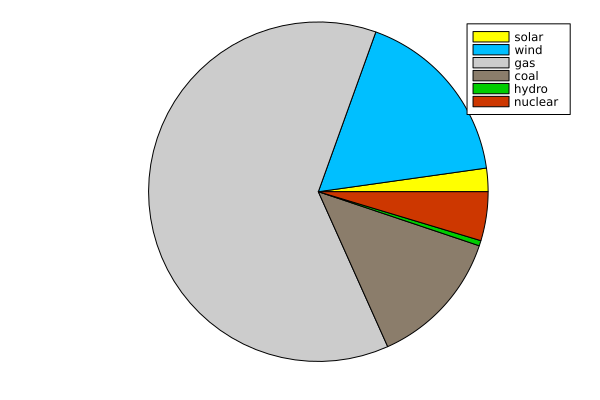

In [6]:
# ------------------ All Existing Power Plants ------------------
plant_data = DataFrame(CSV.File("ERCOTSystem\\texas_plant.csv"))
num_plant = size(plant_data, 1)
plant_data.rowindex = 1:num_plant  # add a row order index
print("Total power plants number is ", num_plant, "\n")

print("Power plant types include ", unique(plant_data.type),"\n")
plant_data_solar = plant_data[ plant_data.type .== "solar", :]
plant_data_wind = plant_data[ plant_data.type .== "wind", :]
plant_data_ng = plant_data[ plant_data.type .== "ng", :] 
plant_data_coal = plant_data[ plant_data.type .== "coal", :]
plant_data_hydro = plant_data[ plant_data.type .== "hydro", :] 
plant_data_nuclear = plant_data[ plant_data.type .== "nuclear", :] 
                            
pg_solar = sum(plant_data_solar.Pmax)
pg_wind = sum(plant_data_wind.Pmax)
pg_ng = sum(plant_data_ng.Pmax)
pg_coal = sum(plant_data_coal.Pmax)
pg_hydro = sum(plant_data_hydro.Pmax)
pg_nuclear = sum(plant_data_nuclear.Pmax)
pg_sum = sum(plant_data.Pmax)

labels = ["solar", "wind", "gas", "coal",  "hydro", "nuclear"] 
sizes = [pg_solar, pg_wind, pg_ng, pg_coal, pg_hydro, pg_nuclear]
print("solar: ", round(pg_solar, digits =3), " MW (", round(pg_solar/pg_sum*100, digits =3), "%) \n", 
      "wind: ", round(pg_wind, digits =3), " MW (", round(pg_wind/pg_sum*100, digits =3), "%) \n", 
      "natural gas: ", round(pg_ng, digits =3), " MW (", round(pg_ng/pg_sum*100, digits =3), "%) \n", 
      "coal: ",  round(pg_coal, digits =3), " MW (", round(pg_coal/pg_sum*100, digits =3), "%) \n", 
      "hydro: ",  round(pg_hydro, digits =3), " MW (", round(pg_hydro/pg_sum*100, digits =3), "%) \n", 
      "nuclear: ",  round(pg_nuclear, digits =3), " MW (", round(pg_nuclear/pg_sum*100, digits =3), "%) \n", 
      "clean energy: ",  round(pg_nuclear+pg_solar+pg_wind+pg_hydro, digits =3), " MW (", round((pg_nuclear+pg_solar+pg_wind+pg_hydro)/pg_sum*100, digits =3), "%) \n", 
      "total: ", round(pg_sum, digits =3), " MW \n")

# plot(labels, sizes,seriestype = :pie, fillcolor= [:brown, :black, :green, :green] )
pie(labels, sizes, color = [:yellow, :deepskyblue1, :gray80, :bisque4, :green3, :orangered3] )               

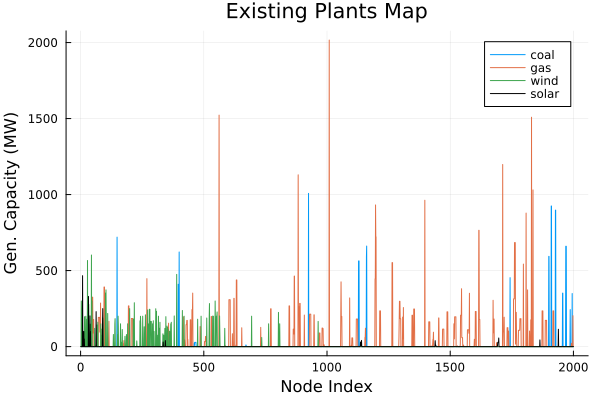

In [7]:
# ----------------- Parameters for Existing Power Plants -----------
num_gen_ng      = size(plant_data_ng,1)
num_gen_coal    = size(plant_data_coal,1)
num_gen_solar   = size(plant_data_solar,1)
num_gen_wind    = size(plant_data_wind,1)
num_gen_hydro   = size(plant_data_hydro,1)
num_gen_nuclear = size(plant_data_nuclear,1)

# generation capacity over time
Pmin_ng = plant_data_ng.Pmin.*ones(1,num_time_sim)
Pmax_ng = plant_data_ng.Pmax.*ones(1,num_time_sim)
ramp_ng_max = dt*2*plant_data_ng.ramp_30
ramp_ng_min = - ramp_ng_max 

Pmin_coal = plant_data_coal.Pmin.*ones(1,num_time_sim)
Pmax_coal = plant_data_coal.Pmax.*ones(1,num_time_sim)
ramp_coal_max = dt*2*plant_data_coal.ramp_30
ramp_coal_min = - ramp_coal_max 

# Construct nodal matrices for power flow
A_coal = zeros(num_bus,num_gen_coal)
A_ng = zeros(num_bus,num_gen_ng)
A_wind = zeros(num_bus,num_gen_wind)
A_solar = zeros(num_bus,num_gen_solar)
A_nuclear = zeros(num_bus,num_gen_nuclear)

for i = 1:num_gen_coal
    bus_index = bus_data[bus_data.bus_id .== plant_data_coal[i,:].bus_id, :].rowindex[1]
    A_coal[bus_index, i] = 1
end

for i = 1:num_gen_ng
    bus_index = bus_data[bus_data.bus_id .== plant_data_ng[i,:].bus_id, :].rowindex[1]
    A_ng[bus_index, i] = 1
end

for i = 1:num_gen_nuclear
    bus_index = bus_data[bus_data.bus_id .== plant_data_nuclear[i,:].bus_id, :].rowindex[1]
    A_nuclear[bus_index, i] = 1
end
P_nuclear = plant_data_nuclear.Pg.*ones(1,num_time_sim)

solar_index = Int32.(zeros(num_gen_solar,1))
for i =1: num_gen_solar
    bus_index = bus_data[bus_data.bus_id .== plant_data_solar[i,:].bus_id, :].rowindex[1]
    A_solar[bus_index, i] = 1
    solar_index[i] = bus_index
end
Pmax_solar = plant_data_solar.Pmax.*coe_PV_t[solar_index[:,1], :]

wind_index = Int32.(zeros(num_gen_wind,1))
for i =1: num_gen_wind
    bus_index = bus_data[bus_data.bus_id .== plant_data_wind[i,:].bus_id, :].rowindex[1]
    A_wind[bus_index, i] = 1
    wind_index[i] = bus_index 
end
Pmax_wind = plant_data_wind.Pmax.*coe_WD_t[wind_index[:,1], :];

# Energy Storage 
cap_ES_max = 2000 # MWh
cap_ES = cap_ES_max*ones(num_bus,1)[:,1]
#cap_ES[800:end] .= 0
 
p_dis_max = 0.25 # MW
p_cha_max = 0.25 # MW
e_max = 1  #MWh
ES_ini = 0.5  # initial SOC is 50%
kap_ES = 0.99 # 100% no leakage

alp_cha = sqrt(0.85)
alp_dis = sqrt(0.85)

# Cost parameters
gencost_data = DataFrame(CSV.File("ERCOTSystem\\texas_gencost.csv"))

c_gen_ng = hcat(gencost_data[plant_data_ng.rowindex,:].c2, 
                gencost_data[plant_data_ng.rowindex,:].c1, 
                gencost_data[plant_data_ng.rowindex,:].c0)/1e3 

c_gen_coal = hcat(gencost_data[plant_data_coal.rowindex,:].c2, 
                  gencost_data[plant_data_coal.rowindex,:].c1, 
                  gencost_data[plant_data_coal.rowindex,:].c0)/1e3  

# investment
c_PV_invest = 890 # k$/MW
c_WD_invest = 1212 # k$/MW
c_ES_invest = 369 # k$/MWh
c_curtail = 0.002 # k$/MWh
c_ES_oper = 0.001  # k$/MWh
c_loadshed = 5  # k$/MWh
c_coal_retire = 117 # k$/MW
c_ng_retire = 15 # k$/MW

# Existing Nodal Capacity of Generation Disrribution
nc_coal = A_coal*Pmax_coal[:,1]
nc_ng = A_ng*Pmax_ng[:,1]
nc_wind = A_wind*plant_data_wind.Pmax
nc_solar = A_solar*plant_data_solar.Pmax;

plot(nc_coal, label = "coal")
plot!(nc_ng, label= "gas")
plot!(nc_wind, label= "wind")
plot!(nc_solar, label= "solar", xlabel = "Node Index", ylabel = "Gen. Capacity (MW)", linecolor = "black", title = "Existing Plants Map")

In [8]:
# ----------------- Line Capacity Expansion
lineexp_data = DataFrame(CSV.File("ERCOTSystem\\line_upgrade_costs.csv"))
cost_lineexp = lineexp_data.cost # k$/MW
cap_lineexp = 2000*ones(num_branch,1);  # maximum capacity increase 2000 MW

# 3- Optimal Planning Model

In [9]:
## ================= Select Optimizer =====================
model_plan = Model(Gurobi.Optimizer)

## ================= Create Variables and Constraints =====================
# Solar  
@variable(model_plan, 0 <= w_PV_var[1:num_bus])
@variable(model_plan, 0 <= p_PV_var[1:num_bus, 1:num_time_sim])
@constraint(model_plan, w_PV_var .<= cap_PV)
@constraint(model_plan, p_PV_var .<= w_PV_var.*coe_PV_t)

# Wind  
@variable(model_plan, 0 <= w_WD_var[1:num_bus])
@variable(model_plan, 0 <= p_WD_var[1:num_bus, 1:num_time_sim])
@constraint(model_plan, w_WD_var .<= cap_WD)
@constraint(model_plan, p_WD_var .<= w_WD_var.*coe_WD_t)

# Existing Solar and Wind
@variable(model_plan, 0 <= p_solar_var[1:num_gen_solar, 1:num_time_sim]) # solar
@variable(model_plan, 0 <= p_wind_var[1:num_gen_wind, 1:num_time_sim]) # wind
@constraint(model_plan, p_wind_var .<= Pmax_wind)
@constraint(model_plan, p_solar_var .<= Pmax_solar)


# Coal Generators
#@variable(model_plan, z_coal_var[1:num_gen_coal], Bin) # coal
@variable(model_plan, 0 <= z_coal_var[1:num_gen_coal] <= 1) # coal
@variable(model_plan, 0 <= p_coal_var[1:num_gen_coal, 1:num_time_sim])
@constraint(model_plan, z_coal_var.*Pmin_coal .<= p_coal_var)
@constraint(model_plan, p_coal_var .<= z_coal_var.*Pmax_coal)
for t = 2:num_time_sim
   @constraint(model_plan,  ramp_coal_min .<= p_coal_var[:,t] - p_coal_var[:,t-1] .<= ramp_coal_max )
end

# Natural Gass
#@variable(model_plan, z_ng_var[1:num_gen_ng], Bin) # natural gas
@variable(model_plan, 0 <= z_ng_var[1:num_gen_ng] <= 1) # natural gas
@variable(model_plan, 0 <= p_ng_var[1:num_gen_ng, 1:num_time_sim])

@constraint(model_plan, z_ng_var.*Pmin_ng .<= p_ng_var)
@constraint(model_plan, p_ng_var .<= z_ng_var.*Pmax_ng);
for t = 2:num_time_sim
   @constraint(model_plan,  ramp_ng_min .<= p_ng_var[:,t] - p_ng_var[:,t-1] .<= ramp_ng_max )
end

# Adjustable Loads
#@variable(model_plan, 0 <= p_load_var[1:num_load, 1:num_time_sim])
#@constraint(model_plan, p_load_min_t .<= p_load_var .<= p_load_max_t)

##  Energy Storage
alp_cha = 1
alp_dis = 1

# --------------------------- full model ------------------------
# @variable(model_plan, nu_ES_var[1:num_bus, 1:num_time_sim], Bin)
@variable(model_plan, 0 <= nu_ES_var[1:num_bus, 1:num_time_sim] <= 1)
@variable(model_plan, 0 <= w_ES_var[1:num_bus])
@variable(model_plan, 0 <= y_ES_var[1:num_bus, 1:num_time_sim] )
@variable(model_plan, 0 <= p_dis_var[1:num_bus, 1:num_time_sim])
@variable(model_plan, 0 <= p_cha_var[1:num_bus, 1:num_time_sim])
@variable(model_plan, 0 <= e_ES_var[1:num_bus, 1:num_time_sim])

big_M = 1e3
@constraint(model_plan, w_ES_var .<= cap_ES)
@constraint(model_plan, p_dis_var .<= p_dis_max*y_ES_var )
@constraint(model_plan, p_cha_var .<= p_cha_max*( w_ES_var*ones(1,num_time_sim) - y_ES_var))
@constraint(model_plan, y_ES_var .<= w_ES_var*ones(1,num_time_sim)) 
@constraint(model_plan, y_ES_var .<= big_M*nu_ES_var)

for t = 1:num_time_sim
    @constraint(model_plan, big_M*nu_ES_var[:,t] - big_M*ones(num_bus,1) + w_ES_var .<= y_ES_var[:,t])
    if t == 1
        @constraint(model_plan, e_ES_var[:,t] .== kap_ES*(ES_ini*e_max*w_ES_var) + dt*(alp_cha*p_cha_var[:,t] - 1/alp_dis*p_dis_var[:,t]))
    else
        @constraint(model_plan, e_ES_var[:,t] .== kap_ES*e_ES_var[:,t-1] + dt*(alp_cha*p_cha_var[:,t] - 1/alp_dis*p_dis_var[:,t]))
    end
    @constraint(model_plan, e_ES_var[:,t] .<= e_max*w_ES_var)
end
@constraint(model_plan, e_ES_var[:,num_time_sim] .== ES_ini*e_max*w_ES_var); # recover to the initial SOC

# # DC Power Flow
@variable(model_plan, P_br_var[1:num_branch, 1:num_time_sim])
@variable(model_plan, tha_var[1:(num_bus-1), 1:num_time_sim]);
# @variable(model_plan, 0 <= cap_br_add_var[1:num_branch]);
# @constraint(model_plan, cap_br_add_var .<= cap_lineexp );

# Power Flow
# @constraint(model_plan, P_br_var .<= P_br_max + cap_br_add_var*ones(1,num_time_sim))
# @constraint(model_plan, P_br_min .<= P_br_var + cap_br_add_var*ones(1,num_time_sim))
@constraint(model_plan, P_br_min .<= P_br_var .<= P_br_max )

@constraint(model_plan, P_br_var .== X_bn[:,2:end]*tha_var)
@constraint(model_plan, A_nb*P_br_var .== p_PV_var + p_WD_var + p_dis_var - p_cha_var - p_load_max_t #  p_load_var   # 
         + A_coal*p_coal_var + A_ng*p_ng_var + A_wind*p_wind_var + A_solar*p_solar_var + A_nuclear*P_nuclear);

# Renewable Penetration
renew_pene = 0.8
@constraint(model_plan, sum(p_coal_var) + sum(p_ng_var) <= (1 - renew_pene)*sum(p_load_max_t));
#@constraint(model_plan, sum(w_PV_var + w_WD_var) + sum() >= gam_C*sum(z_gen_var.*cap_gen) )

Academic license - for non-commercial use only


In [10]:
## ================= Define Objective =====================
num_years = 10*365

Obj_invest = sum(c_PV_invest*w_PV_var) +  sum(c_WD_invest*w_WD_var) + sum(c_ES_invest*w_ES_var)
Obj_retire_coal =  sum(c_coal_retire*(ones(num_gen_coal,1)-z_coal_var).*Pmax_coal[:,1]) 
Obj_retire_ng =  sum(c_ng_retire*(ones(num_gen_ng,1)-z_ng_var).*Pmax_ng[:,1]) 
Obj_line_expansion =  0 # sum(cost_lineexp.*cap_br_add_var)

Obj_opera =  c_curtail*(sum( w_PV_var.*coe_PV_t - p_PV_var) + sum( w_WD_var.*coe_WD_t - p_WD_var)
           + sum(Pmax_wind - p_wind_var) + sum(Pmax_solar-p_solar_var)) + c_ES_oper*sum(p_dis_var + p_cha_var)
         # + c_loadshed*sum(p_load_max_t - p_load_var)
         
for i = 1:num_gen_coal
    Obj_opera =  Obj_opera + sum(c_gen_coal[i,2]*p_coal_var[i,:] + z_coal_var[i]*c_gen_coal[i,3]*ones(num_time_sim,1))
                       + sum(c_gen_coal[i,1]*(p_coal_var[i,:].^2) )
end

for i = 1:num_gen_ng
    Obj_opera =  Obj_opera + sum( c_gen_ng[i,2]*p_ng_var[i,:] + z_ng_var[i]*c_gen_ng[i,3]*ones(num_time_sim,1))
                       + sum(c_gen_ng[i,1]*(p_ng_var[i,:].^2))
end

Obj_exp = Obj_invest + Obj_retire_coal + Obj_retire_ng + Obj_line_expansion + Obj_opera*num_years*dt

@objective(model_plan, Min, Obj_exp);

## ================= Solve model =======================
tick()
optimize!(model_plan)
tock()

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 341446 rows, 286824 columns and 937933 nonzeros
Model fingerprint: 0x18d1517e
Coefficient statistics:
  Matrix range     [1e-02, 1e+03]
  Objective range  [7e+00, 4e+05]
  Bounds range     [1e+00, 4e+03]
  RHS range        [6e-02, 1e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 167640 rows and 136360 columns
Presolve time: 0.98s
Presolved: 173806 rows, 150464 columns, 586116 nonzeros

Ordering time: 3.38s

Barrier statistics:
 AA' NZ     : 2.053e+06
 Factor NZ  : 1.799e+07 (roughly 300 MBytes of memory)
 Factor Ops : 1.414e+10 (roughly 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.12814567e+11 -9.42996552e+11  9.90e+06 3.08e+03  6.74e+08     6s
   1   8.85561407e+10 -1.09029768e+12  5.51e+06 6.24e+04  3.52e+08     7s
   2   5.0

┌ Info:  started timer at: 2023-03-07T11:55:29.784
└ @ TickTock C:\Users\16895\.julia\packages\TickTock\fGILW\src\TickTock.jl:54
┌ Info:          181.5190617s: 3 minutes, 1 second, 519 milliseconds
└ @ TickTock C:\Users\16895\.julia\packages\TickTock\fGILW\src\TickTock.jl:62


Investment Cost: 109.433 billion $
Solar Investment Cost: 36.805 billion $
Wind Investment Cost: 68.821 billion $
Storage Investment Cost: 3.807 billion $
Gas Decommission Cost: 0.835 billion $
Coal Decommission Cost: 0.351 billion $
Line Expansion Cost: 0.0 billion $
Operational Cost: 7898.594 k$
solar: 329815.914 MWh (23.937%) 
wind: 656502.977 MWh (47.648%) 
natural gas: 153726.681 MWh (11.157%) 
coal: 121712.247 MWh (8.834%) 
nuclear: 116063.76 MWh (8.424%) 
clean energy: 1.102382652e6 MWh (80.009%) 
total generation: 1.37782158e6 MWh 
total load: 1.37719464e6 MWh 
New solar installation cap: 41.354 (GW)
New wind installation cap: 56.783 (GW)
New energy storage installation cap: 10.316 (GWh)
Line expansion cap: 0.0 (GW)


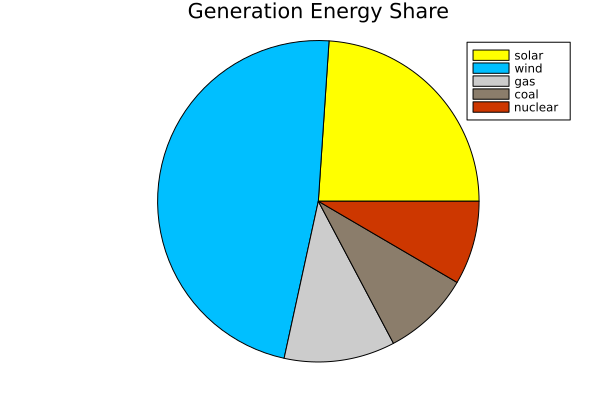

In [11]:
# Get and Save optimal solution values
w_PV = value.(w_PV_var)
p_PV = value.(p_PV_var)
w_WD = value.(w_WD_var)
p_WD = value.(p_WD_var)
p_solar = value.(p_solar_var)
p_wind = value.(p_wind_var)
z_coal = value.(z_coal_var)
p_coal = value.(p_coal_var)
z_ng = value.(z_ng_var)
p_ng = value.(p_ng_var)
nu_ES = value.(nu_ES_var)
w_ES = value.(w_ES_var)
y_ES = value.(y_ES_var)
p_dis = value.(p_dis_var)
p_cha = value.(p_cha_var)
e_ES = value.(e_ES_var)
P_br = value.(P_br_var)
tha = value.(tha_var)
cap_br_add = zeros(num_branch,1)  #value.(cap_br_add_var)
P_br_ava = P_br_max  - abs.(P_br) #+ cap_br_add*ones(1,num_time_sim)  # ==0: binding line
p_load = p_load_max_t

invcost_WD = sum(c_WD_invest*w_WD)/1e6 # billion $
invcost_PV = sum(c_PV_invest*w_PV)/1e6 # billion $
invcost_ES = sum(c_ES_invest*w_ES)/1e6 # billion $
invcost_line = value(Obj_line_expansion)/1e6
invcost_total = invcost_WD + invcost_PV + invcost_ES + invcost_line
decost_ng = value(Obj_retire_ng)/1e6
decost_coal = value(Obj_retire_coal )/1e6
decost_total = (decost_ng + decost_coal)/1e6
cost_plan = (invcost_total + decost_total)/1e6
cost_oper = dt*value(Obj_opera)/1e6

# save data and results
using JLD2, Tables
jldsave("ERCOT_Test_Save\\Testcase_26.jld2"; w_PV, p_PV, w_WD, p_WD, p_solar, p_wind, z_coal, p_coal,
                 z_ng, p_ng, nu_ES, w_ES, y_ES, p_dis, p_cha, e_ES, P_br, tha, P_br_ava,cap_br_add,
                 invcost_WD, invcost_PV, invcost_ES, invcost_line, invcost_total, decost_ng, decost_coal, cost_plan,cost_oper);

print("Investment Cost: ", round(value(Obj_invest+ Obj_line_expansion)/1e6,digits =3), " billion \$\n")
print("Solar Investment Cost: ", round(sum(c_PV_invest*(w_PV))/1e6,digits =3), " billion \$\n")
print("Wind Investment Cost: ", round(sum(c_WD_invest*w_WD)/1e6,digits =3), " billion \$\n")
print("Storage Investment Cost: ", round(sum(c_ES_invest*w_ES)/1e6,digits =3), " billion \$\n")
print("Gas Decommission Cost: ", round(value(Obj_retire_ng)/1e6,digits =3), " billion \$\n")
print("Coal Decommission Cost: ", round(value(Obj_retire_coal )/1e6,digits =3), " billion \$\n")
print("Line Expansion Cost: ", round(value(Obj_line_expansion)/1e6,digits =3), " billion \$\n")
print("Operational Cost: ", round(dt*value(Obj_opera),digits =3), " k\$\n")

## ================= Show Results =======================
E_solar = dt*(sum(p_PV) + sum(p_solar))
E_wind = dt*(sum(p_WD) + sum(p_wind))
E_coal = dt*sum(p_coal)
E_ng = dt*sum(p_ng)
E_nuclear = dt*sum(P_nuclear)
E_gen = E_solar + E_wind + E_coal + E_ng + E_nuclear
E_load = dt*sum(p_load)

labels = ["solar"; "wind"; "gas";"coal"; "nuclear"] 
sizes = [E_solar; E_wind; E_ng; E_coal; E_nuclear]
print("solar: ", round(E_solar, digits =3), " MWh (", round(E_solar/E_gen*100, digits =3), "%) \n", 
      "wind: ", round(E_wind, digits =3), " MWh (", round(E_wind/E_gen*100, digits =3), "%) \n", 
      "natural gas: ", round(E_ng, digits =3), " MWh (", round(E_ng/E_gen*100, digits =3), "%) \n", 
      "coal: ",  round(E_coal, digits =3), " MWh (", round(E_coal/E_gen*100, digits =3), "%) \n", 
      "nuclear: ",  round(E_nuclear, digits =3), " MWh (", round(E_nuclear/E_gen*100, digits =3), "%) \n", 
      "clean energy: ",  round(E_nuclear+E_solar+E_wind, digits =3), " MWh (", round((E_nuclear+E_solar+E_wind)/E_gen*100, digits =3), "%) \n", 
      "total generation: ", round(E_gen, digits =3), " MWh \n",
      "total load: ", round(E_load, digits =3), " MWh \n")


# Planned Nodal Capacity of Generation Disrribution
print("New solar installation cap: ", round(sum(w_PV)/1e3, digits =3)," (GW)\n")
print("New wind installation cap: ", round(sum(w_WD)/1e3, digits =3)," (GW)\n")
print("New energy storage installation cap: ", round(sum(w_ES)/1e3, digits =3)," (GWh)\n")
print("Line expansion cap: ", round(sum(cap_br_add)/1e3, digits =3)," (GW)\n")

# fig_energy = plot(labels, sizes,seriestype = :pie, title = "Generation Energy Share" )
fig_energy = pie(labels, sizes, color = [:yellow, :deepskyblue1, :gray80, :bisque4, :orangered3] ,title = "Generation Energy Share" )
display(fig_energy)


# 4- Optimal Deterministic Operation Model

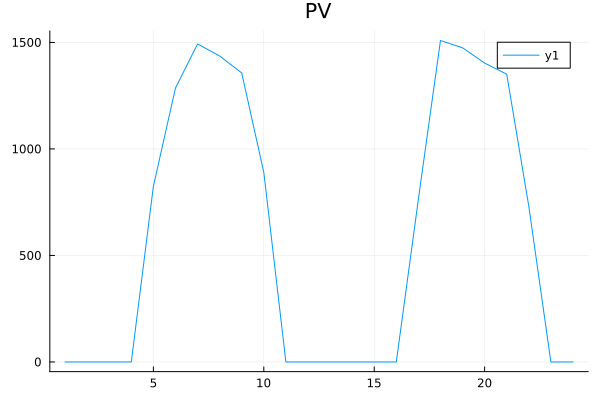

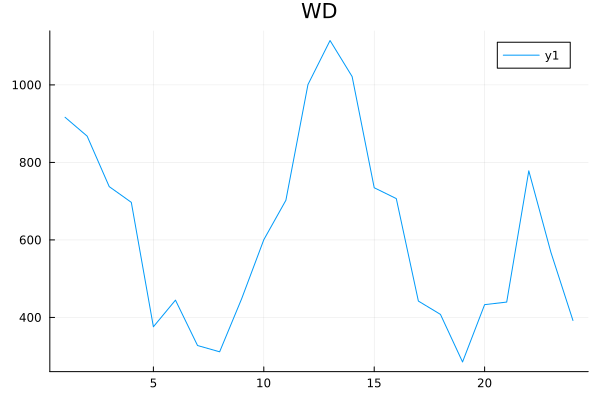

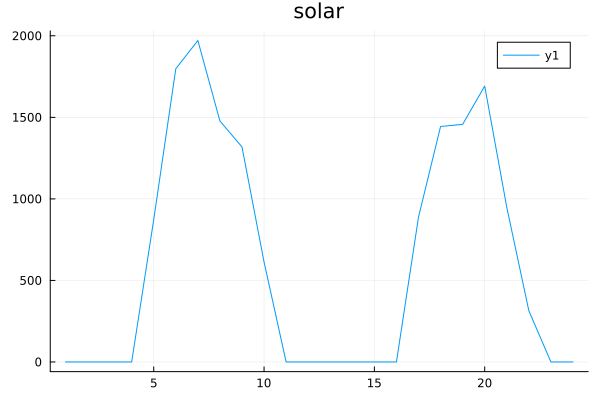

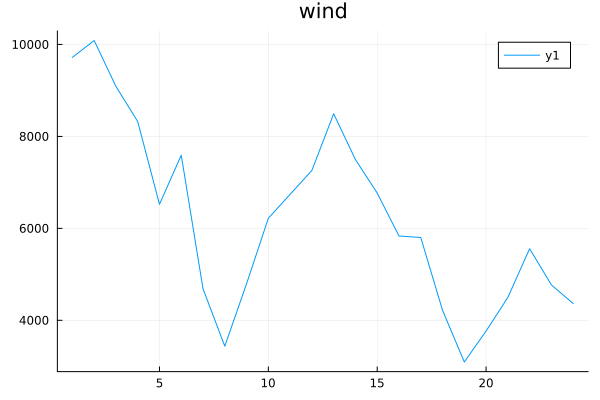

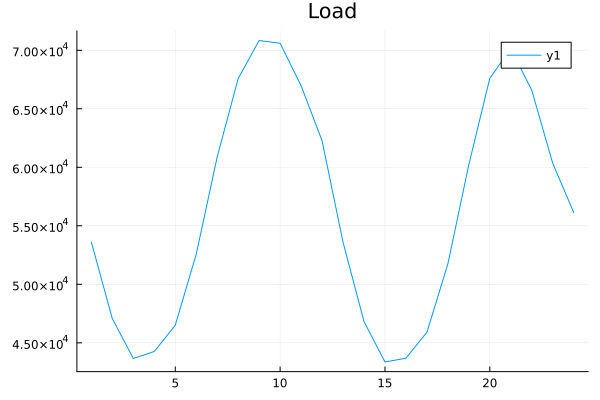

3206×12 Matrix{Float64}:
  -221.0   -221.0   -221.0   -221.0  …   -221.0   -221.0   -221.0   -221.0
  -221.0   -221.0   -221.0   -221.0      -221.0   -221.0   -221.0   -221.0
  -221.0   -221.0   -221.0   -221.0      -221.0   -221.0   -221.0   -221.0
  -221.0   -221.0   -221.0   -221.0      -221.0   -221.0   -221.0   -221.0
   -98.0    -98.0    -98.0    -98.0       -98.0    -98.0    -98.0    -98.0
   -98.0    -98.0    -98.0    -98.0  …    -98.0    -98.0    -98.0    -98.0
  -250.0   -250.0   -250.0   -250.0      -250.0   -250.0   -250.0   -250.0
  -221.0   -221.0   -221.0   -221.0      -221.0   -221.0   -221.0   -221.0
  -196.0   -196.0   -196.0   -196.0      -196.0   -196.0   -196.0   -196.0
  -523.0   -523.0   -523.0   -523.0      -523.0   -523.0   -523.0   -523.0
   -42.0    -42.0    -42.0    -42.0  …    -42.0    -42.0    -42.0    -42.0
  -149.0   -149.0   -149.0   -149.0      -149.0   -149.0   -149.0   -149.0
  -221.0   -221.0   -221.0   -221.0      -221.0   -221.0   -221.0   -221.0


In [14]:
# Build the operation period
num_time_op = 24 # total: 8784 h
dt_op = 2   # time gap 1h
time_ini_op = 5375-17
T_sim_op = time_ini_op:dt_op:(time_ini_op + dt_op*num_time_op - 1)

num_time_sim_rh = 12  # receding horizon window length

# get solar and wind data
coe_PV_t_op = coe_PV_t_all[:,T_sim_op]
fig1 = plot(sum(coe_PV_t_op, dims =1)', title = "PV");  display(fig1)

coe_WD_t_op = coe_WD_t_all[:,T_sim_op]
fig2 = plot(sum(coe_WD_t_op, dims =1)', title = "WD");  display(fig2)

Pmax_solar_op = plant_data_solar.Pmax.*coe_PV_t_op[solar_index[:,1], :]
Pmax_wind_op  = plant_data_wind.Pmax.*coe_WD_t_op[wind_index[:,1], :];

fig3 = plot(sum(Pmax_solar_op, dims =1)', title = "solar");  display(fig3)
fig4 = plot(sum(Pmax_wind_op, dims =1)', title = "wind");  display(fig4)

# get load data
p_load_t_op = p_load_t_all[:, T_sim_op]    # unit: MW
p_load_max_t_op = abs.(p_load_t_op);
p_load_min_t_op = 0.2*p_load_max_t_op;
fig5 = plot(sum(p_load_t_op, dims =1)', title = "Load"); display(fig5)


# generation capacity over time
Pmin_ng_rh = plant_data_ng.Pmin.*ones(1,num_time_sim_rh)
Pmax_ng_rh = plant_data_ng.Pmax.*ones(1,num_time_sim_rh)
# ramp_ng_max = dt*2*plant_data_ng.ramp_30
# ramp_ng_min = - ramp_ng_max 

Pmin_coal_rh = plant_data_coal.Pmin.*ones(1,num_time_sim_rh)
Pmax_coal_rh = plant_data_coal.Pmax.*ones(1,num_time_sim_rh)
# ramp_coal_max = dt*2*plant_data_coal.ramp_30
# ramp_coal_min = - ramp_coal_max 

P_br_max_rh = P_br_max[:,1:num_time_sim_rh]
P_br_min_rh = P_br_min[:,1:num_time_sim_rh]

In [18]:
## Enter Receding Horizon (RH) Process
# Initialization
num_opti= num_time_op - num_time_sim_rh + 1

# Decisions 
p_PV_rh = zeros(num_bus, num_opti)
p_WD_rh = zeros(num_bus, num_opti)
p_solar_rh = zeros(num_gen_solar, num_opti)
p_wind_rh = zeros(num_gen_wind, num_opti)
p_coal_rh = zeros(num_gen_coal, num_opti)
p_ng_rh = zeros(num_gen_ng, num_opti)
nu_ES_rh = zeros(num_bus, num_opti)
p_dis_rh = zeros(num_bus, num_opti)
p_cha_rh = zeros(num_bus, num_opti)
e_ES_rh = zeros(num_bus, num_opti)
P_br_rh = zeros(num_branch, num_opti)
tha_rh = zeros(num_bus-1, num_opti)
p_load_rh = zeros(num_load, num_opti)
oper_cost_rh_1 = zeros(1, num_opti)
oper_cost_rh_sum = zeros(1, num_opti)

wind_cost_rh = zeros(1, num_opti)
solar_cost_rh = zeros(1, num_opti)
ng_cost_rh = zeros(1, num_opti)
coal_cost_rh = zeros(1, num_opti)
ES_cost_rh = zeros(1, num_opti)
load_cost_rh = zeros(1, num_opti)

# enter receding horizon

# k_rh = 1
for k_rh = 1:num_opti

    coe_PV_t_rh = coe_PV_t_op[:, k_rh:(k_rh + num_time_sim_rh - 1)]
    coe_WD_t_rh = coe_WD_t_op[:, k_rh:(k_rh + num_time_sim_rh - 1)]

    Pmax_wind_rh = Pmax_wind_op[:, k_rh:(k_rh + num_time_sim_rh - 1)]
    Pmax_solar_rh = Pmax_solar_op[:, k_rh:(k_rh + num_time_sim_rh - 1)]


    ## ================= Select Optimizer =====================
    model_oper = Model(Gurobi.Optimizer)

    ## ================= Create Variables and Constraints =====================
    # Solar  
    @variable(model_oper, 0 <= p_PV_var[1:num_bus, 1:num_time_sim_rh])
    @constraint(model_oper, p_PV_var .<= w_PV.*coe_PV_t_rh)

    # Wind  
    @variable(model_oper, 0 <= p_WD_var[1:num_bus, 1:num_time_sim_rh])
    @constraint(model_oper, p_WD_var .<= w_WD.*coe_WD_t_rh)

    # Existing Solar and Wind
    @variable(model_oper, 0 <= p_solar_var[1:num_gen_solar, 1:num_time_sim_rh]) # solar
    @variable(model_oper, 0 <= p_wind_var[1:num_gen_wind, 1:num_time_sim_rh]) # wind
    @constraint(model_oper, p_wind_var .<= Pmax_wind_rh)
    @constraint(model_oper, p_solar_var .<= Pmax_solar_rh)

    # Coal Generators: binary z_coal is from planning for decommission
    @variable(model_oper, 0 <= p_coal_var[1:num_gen_coal, 1:num_time_sim_rh])
    @constraint(model_oper, z_coal.*Pmin_coal_rh .<= p_coal_var)
    @constraint(model_oper, p_coal_var .<= z_coal.*Pmax_coal_rh)
    for t = 2:num_time_sim_rh
       @constraint(model_oper,  ramp_coal_min .<= p_coal_var[:,t] - p_coal_var[:,t-1] .<= ramp_coal_max )
    end
    if k_rh >= 2  # ramping to previous step
       @constraint(model_oper,  ramp_coal_min .<= p_coal_var[:,1] - p_coal_rh[:,k_rh-1] .<= ramp_coal_max )
    end

    # Natural Gass
    @variable(model_oper, 0 <= p_ng_var[1:num_gen_ng, 1:num_time_sim_rh])
    @constraint(model_oper, z_ng.*Pmin_ng_rh .<= p_ng_var)
    @constraint(model_oper, p_ng_var .<= z_ng.*Pmax_ng_rh);
    for t = 2:num_time_sim_rh
       @constraint(model_oper,  ramp_ng_min .<= p_ng_var[:,t] - p_ng_var[:,t-1] .<= ramp_ng_max )
    end
    if k_rh >= 2  # ramping to previous step
       @constraint(model_oper,  ramp_ng_min .<= p_ng_var[:,1] - p_ng_rh[:, k_rh-1] .<= ramp_ng_max )
    end

    # Adjustable Loads
    p_load_max_t_rh = p_load_max_t_op[:, k_rh:(k_rh + num_time_sim_rh - 1)]
    p_load_min_t_rh = p_load_min_t_op[:, k_rh:(k_rh + num_time_sim_rh - 1)]
    @variable(model_oper, 0 <= p_load_var[1:num_load, 1:num_time_sim_rh])
    @constraint(model_oper, p_load_min_t_rh .<= p_load_var .<= p_load_max_t_rh)

    ##  Energy Storage
    alp_cha = 1
    alp_dis = 1

    # --------------------------- full model ------------------------
    # @variable(model_oper, nu_ES_var[1:num_bus, 1:num_time_sim], Bin)
    @variable(model_oper, 0 <= nu_ES_var[1:num_bus, 1:num_time_sim_rh] <= 1)
    @variable(model_oper, 0 <= p_dis_var[1:num_bus, 1:num_time_sim_rh])
    @variable(model_oper, 0 <= p_cha_var[1:num_bus, 1:num_time_sim_rh])
    @variable(model_oper, 0 <= e_ES_var[1:num_bus, 1:num_time_sim_rh])

    big_M = 1e3
    scale_ES = 20

    if k_rh == 1
        e_ES_ini = scale_ES*ES_ini*e_max*w_ES  # the first step is initial
    else
        e_ES_ini = e_ES_rh[:,k_rh-1]  # k_rh >=2 use the previous solution
    end

    for t = 1:num_time_sim_rh
        @constraint(model_oper, p_dis_var[:,t] .<= scale_ES*p_dis_max*(w_ES.*nu_ES_var[:,t]) )
        @constraint(model_oper, p_cha_var[:,t] .<= scale_ES*p_cha_max*(w_ES.*(ones(num_bus,1) - nu_ES_var[:,t]) ))

        if t == 1
            @constraint(model_oper, e_ES_var[:,t] .== kap_ES*e_ES_ini + dt*(alp_cha*p_cha_var[:,t] - 1/alp_dis*p_dis_var[:,t]))
        else
            @constraint(model_oper, e_ES_var[:,t] .== kap_ES*e_ES_var[:,t-1] + dt*(alp_cha*p_cha_var[:,t] - 1/alp_dis*p_dis_var[:,t]))
        end
        @constraint(model_oper, e_ES_var[:,t] .<= scale_ES*e_max*w_ES)
    end
#     @constraint(model_oper, e_ES_var[:,num_time_sim_rh] .== e_ES_ini); # recover to the initial SOC


    # # DC Power Flow
    @variable(model_oper, P_br_var[1:num_branch, 1:num_time_sim_rh])
    @variable(model_oper, tha_var[1:(num_bus-1), 1:num_time_sim_rh]);


    # Power Flow
    # @constraint(model_oper, P_br_var .<= P_br_max_rh + cap_br_add*ones(1,num_time_sim_rh))
    # @constraint(model_oper, P_br_min_rh .<= P_br_var + cap_br_add*ones(1,num_time_sim_rh))
    @constraint(model_oper, P_br_min_rh .<= P_br_var .<= P_br_max_rh )

    @constraint(model_oper, P_br_var .== X_bn[:,2:end]*tha_var)
    @constraint(model_oper, A_nb*P_br_var .== p_PV_var + p_WD_var + p_dis_var - p_cha_var - p_load_max_t_rh #  p_load_var   # 
             + A_coal*p_coal_var + A_ng*p_ng_var + A_wind*p_wind_var + A_solar*p_solar_var + A_nuclear*P_nuclear[:,1:num_time_sim_rh]);


    ## ================= Define Operation Objective =====================
    Obj_op_solar = dt*c_curtail*(sum( w_PV.*coe_PV_t_rh - p_PV_var, dims =1) + sum(Pmax_solar_rh - p_solar_var, dims =1))
    Obj_op_wind  = dt*c_curtail*(sum( w_WD.*coe_WD_t_rh - p_WD_var, dims =1) + sum(Pmax_wind_rh - p_wind_var, dims =1) )
    Obj_op_ES = dt*c_ES_oper*sum(p_dis_var + p_cha_var, dims =1)
    Obj_op_load = dt*c_loadshed*sum(p_load_max_t_rh - p_load_var, dims =1)

    Obj_op_coal = zeros(num_time_sim_rh,1)
    for i = 1:num_gen_coal
        Obj_op_coal =  Obj_op_coal + dt*(c_gen_coal[i,2]*p_coal_var[i,:] .+ z_coal[i]*c_gen_coal[i,3])
                           + dt*(c_gen_coal[i,1]*(p_coal_var[i,:].^2) )
    end

    Obj_op_ng = zeros(num_time_sim_rh,1)
    for i = 1:num_gen_ng
        Obj_op_ng =  Obj_op_ng + dt*( c_gen_ng[i,2]*p_ng_var[i,:] .+ z_ng[i]*c_gen_ng[i,3])
                           + dt*(c_gen_ng[i,1]*(p_ng_var[i,:].^2))
    end

    Obj_oper =  Obj_op_solar  +  Obj_op_wind  +   Obj_op_ES  +  Obj_op_load + Obj_op_coal' +  Obj_op_ng' 

    # Obj_oper = sum(Obj_op_solar) + sum(Obj_op_wind) +  sum(Obj_op_ES) + sum(Obj_op_coal) + sum(Obj_op_ng) # from power to energy

    @objective(model_oper, Min, sum(Obj_oper));

    ## =========================== Solve model =========================
    tick()
    optimize!(model_oper)
    tock()

    # =========== Get and Save optimal solution values at the first step
    p_PV_rh[:,k_rh] = value.(p_PV_var)[:,1]
    p_WD_rh[:,k_rh] = value.(p_WD_var)[:,1]
    p_solar_rh[:,k_rh] = value.(p_solar_var)[:,1]
    p_wind_rh[:,k_rh] = value.(p_wind_var)[:,1]
    p_coal_rh[:,k_rh] = value.(p_coal_var)[:,1]
    p_ng_rh[:,k_rh] = value.(p_ng_var)[:,1]
    nu_ES_rh[:,k_rh] = value.(nu_ES_var)[:,1]
    p_dis_rh[:,k_rh] = value.(p_dis_var)[:,1]
    p_cha_rh[:,k_rh] = value.(p_cha_var)[:,1]
    e_ES_rh[:,k_rh] = value.(e_ES_var)[:,1]
    P_br_rh[:,k_rh] = value.(P_br_var)[:,1]
    tha_rh[:,k_rh] = value.(tha_var)[:,1]
    p_load_rh[:,k_rh] = value.(p_load_var)[:,1]

    # ---- cost by categories
    oper_cost_rh_1[k_rh] = value.(Obj_oper)[1]
    oper_cost_rh_sum[k_rh] = sum(value.(Obj_oper))
    wind_cost_rh[k_rh] = value.(Obj_op_wind)[1]  
    solar_cost_rh[k_rh] =  value.(Obj_op_solar)[1]
    ng_cost_rh[k_rh] =  value.(Obj_op_ng)[1]
    coal_cost_rh[k_rh] = value.(Obj_op_coal)[1]
    ES_cost_rh[k_rh] =  value.(Obj_op_ES)[1]
    load_cost_rh[k_rh] =  value.(Obj_op_load)[1]

    print(k_rh, ", Operation Cost: ", oper_cost_rh_sum[k_rh]/1e3, " (million)")
    
end

Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 285445 rows, 304405 columns and 661375 nonzeros
Model fingerprint: 0x9ee9850d
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [2e-03, 1e+01]
  Bounds range     [1e-02, 4e+03]
  RHS range        [5e-02, 2e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 261311 rows and 275134 columns
Presolve time: 0.50s
Presolved: 24134 rows, 29271 columns, 125868 nonzeros

Ordering time: 0.22s

Barrier statistics:
 AA' NZ     : 2.491e+05
 Factor NZ  : 1.359e+06 (roughly 30 MBytes of memory)
 Factor Ops : 1.212e+08 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.80615096e+05 -4.32220562e+06  5.12e+04 9.09e-02  7.37e+03     1s
   1   2.52231432e+04 -4.66975718e+06 

┌ Info:  started timer at: 2023-03-07T12:15:40.493
└ @ TickTock C:\Users\16895\.julia\packages\TickTock\fGILW\src\TickTock.jl:54
┌ Info:            5.2521196s: 5 seconds, 252 milliseconds
└ @ TickTock C:\Users\16895\.julia\packages\TickTock\fGILW\src\TickTock.jl:62


1, Operation Cost: 6.450639049534953 (million)Academic license - for non-commercial use only


┌ Info:  started timer at: 2023-03-07T12:15:55.032
└ @ TickTock C:\Users\16895\.julia\packages\TickTock\fGILW\src\TickTock.jl:54


Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 285864 rows, 304824 columns and 662213 nonzeros
Model fingerprint: 0x4ffbb5e9
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [2e-03, 1e+01]
  Bounds range     [1e-02, 4e+03]
  RHS range        [5e-02, 2e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 261733 rows and 275561 columns
Presolve time: 0.52s
Presolved: 24131 rows, 29263 columns, 125852 nonzeros

Ordering time: 0.23s

Barrier statistics:
 AA' NZ     : 2.491e+05
 Factor NZ  : 1.343e+06 (roughly 30 MBytes of memory)
 Factor Ops : 1.169e+08 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.80807382e+05 -4.32289064e+06  5.12e+04 9.09e-02  7.37e+03     1s
   1   2.53301369e+04 -4.67955815e+06  7.54e+03 4.01e-01  1.17e+03     1s
   2   1.74

┌ Info:            6.2044395s: 6 seconds, 204 milliseconds
└ @ TickTock C:\Users\16895\.julia\packages\TickTock\fGILW\src\TickTock.jl:62


Academic license - for non-commercial use only


┌ Info:  started timer at: 2023-03-07T12:16:11.255
└ @ TickTock C:\Users\16895\.julia\packages\TickTock\fGILW\src\TickTock.jl:54


Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 285864 rows, 304824 columns and 662213 nonzeros
Model fingerprint: 0x8dd93381
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [2e-03, 1e+01]
  Bounds range     [1e-02, 4e+03]
  RHS range        [5e-02, 2e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 261740 rows and 275574 columns
Presolve time: 0.57s
Presolved: 24124 rows, 29250 columns, 125833 nonzeros

Ordering time: 0.21s

Barrier statistics:
 AA' NZ     : 2.492e+05
 Factor NZ  : 1.349e+06 (roughly 30 MBytes of memory)
 Factor Ops : 1.195e+08 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.82102349e+05 -4.32384850e+06  5.12e+04 9.09e-02  7.37e+03     1s
   1   2.54144096e+04 -4.68007619e+06  7.55e+03 4.02e-01  1.17e+03     1s
   2   1.75

┌ Info:            6.2120245s: 6 seconds, 212 milliseconds
└ @ TickTock C:\Users\16895\.julia\packages\TickTock\fGILW\src\TickTock.jl:62


3, Operation Cost: 6.3976978701962475 (million)Academic license - for non-commercial use only


┌ Info:  started timer at: 2023-03-07T12:16:26.838
└ @ TickTock C:\Users\16895\.julia\packages\TickTock\fGILW\src\TickTock.jl:54


Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 285864 rows, 304824 columns and 662213 nonzeros
Model fingerprint: 0xb82e8754
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [2e-03, 1e+01]
  Bounds range     [1e-02, 4e+03]
  RHS range        [5e-02, 2e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 261748 rows and 275587 columns
Presolve time: 0.52s
Presolved: 24116 rows, 29237 columns, 125791 nonzeros

Ordering time: 0.22s

Barrier statistics:
 AA' NZ     : 2.491e+05
 Factor NZ  : 1.350e+06 (roughly 30 MBytes of memory)
 Factor Ops : 1.194e+08 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.83790469e+05 -4.32076637e+06  5.13e+04 9.07e-02  7.38e+03     1s
   1   2.54958395e+04 -4.65481744e+06  7.56e+03 3.99e-01  1.17e+03     1s
   2   1.74

┌ Info:            5.3498773s: 5 seconds, 349 milliseconds
└ @ TickTock C:\Users\16895\.julia\packages\TickTock\fGILW\src\TickTock.jl:62


4, Operation Cost: 6.41805655701499 (million)Academic license - for non-commercial use only


┌ Info:  started timer at: 2023-03-07T12:16:41.120
└ @ TickTock C:\Users\16895\.julia\packages\TickTock\fGILW\src\TickTock.jl:54


Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 285864 rows, 304824 columns and 662213 nonzeros
Model fingerprint: 0xb0401ff9
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [2e-03, 1e+01]
  Bounds range     [1e-02, 4e+03]
  RHS range        [5e-02, 2e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 261764 rows and 275603 columns
Presolve time: 0.52s
Presolved: 24100 rows, 29221 columns, 125741 nonzeros

Ordering time: 0.23s

Barrier statistics:
 AA' NZ     : 2.491e+05
 Factor NZ  : 1.339e+06 (roughly 30 MBytes of memory)
 Factor Ops : 1.171e+08 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.83482431e+05 -4.31448113e+06  5.10e+04 9.06e-02  7.34e+03     1s
   1   2.55995227e+04 -4.65125109e+06  7.51e+03 3.84e-01  1.16e+03     1s
   2   1.74

┌ Info:            5.9518307s: 5 seconds, 951 milliseconds
└ @ TickTock C:\Users\16895\.julia\packages\TickTock\fGILW\src\TickTock.jl:62


 (million)Academic license - for non-commercial use only


┌ Info:  started timer at: 2023-03-07T12:16:56.155
└ @ TickTock C:\Users\16895\.julia\packages\TickTock\fGILW\src\TickTock.jl:54


Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 285864 rows, 304824 columns and 662213 nonzeros
Model fingerprint: 0xfb9926f8
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [2e-03, 1e+01]
  Bounds range     [1e-02, 4e+03]
  RHS range        [5e-02, 2e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 261760 rows and 275599 columns
Presolve time: 0.69s
Presolved: 24104 rows, 29225 columns, 125756 nonzeros

Ordering time: 0.25s

Barrier statistics:
 AA' NZ     : 2.491e+05
 Factor NZ  : 1.370e+06 (roughly 30 MBytes of memory)
 Factor Ops : 1.237e+08 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.83072915e+05 -4.31597707e+06  5.10e+04 9.11e-02  7.34e+03     1s
   1   2.49569153e+04 -4.65036054e+06  7.44e+03 3.89e-01  1.15e+03     1s
   2   1.74

┌ Info:            6.3162806s: 6 seconds, 316 milliseconds
└ @ TickTock C:\Users\16895\.julia\packages\TickTock\fGILW\src\TickTock.jl:62


Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 285864 rows, 304824 columns and 662213 nonzeros
Model fingerprint: 0xcdf1b865
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [2e-03, 1e+01]
  Bounds range     [1e-02, 4e+03]
  RHS range        [5e-02, 2e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 261755 rows and 275595 columns
Presolve time: 0.48s
Presolved: 24109 rows, 29229 columns, 125771 nonzeros

Ordering time: 0.22s

Barrier statistics:
 AA' NZ     : 2.491e+05
 Factor NZ  : 1.352e+06 (roughly 30 MBytes of memory)
 Factor Ops : 1.198e+08 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.83750983e+05 -4.31778723e+06  5.10e+04 9.10e-02  7.34e+03     1s
   1   2.50536584e+04 -4.65076732e+06 

┌ Info:  started timer at: 2023-03-07T12:17:11.312
└ @ TickTock C:\Users\16895\.julia\packages\TickTock\fGILW\src\TickTock.jl:54
┌ Info:             5.849151s: 5 seconds, 849 milliseconds
└ @ TickTock C:\Users\16895\.julia\packages\TickTock\fGILW\src\TickTock.jl:62


7, Operation Cost: 6.483690605094114 (million)Academic license - for non-commercial use only


┌ Info:  started timer at: 2023-03-07T12:17:26.239
└ @ TickTock C:\Users\16895\.julia\packages\TickTock\fGILW\src\TickTock.jl:54


Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 285864 rows, 304824 columns and 662213 nonzeros
Model fingerprint: 0xdd595dcc
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [2e-03, 1e+01]
  Bounds range     [1e-02, 4e+03]
  RHS range        [5e-02, 2e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 261759 rows and 275608 columns
Presolve time: 0.55s
Presolved: 24105 rows, 29216 columns, 125741 nonzeros

Ordering time: 0.22s

Barrier statistics:
 AA' NZ     : 2.491e+05
 Factor NZ  : 1.350e+06 (roughly 30 MBytes of memory)
 Factor Ops : 1.195e+08 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.85895427e+05 -4.31591476e+06  5.10e+04 9.10e-02  7.35e+03     1s
   1   2.53882000e+04 -4.64790161e+06  7.45e+03 3.94e-01  1.15e+03     1s
   2   1.78

┌ Info:             5.985948s: 5 seconds, 985 milliseconds
└ @ TickTock C:\Users\16895\.julia\packages\TickTock\fGILW\src\TickTock.jl:62


8, Operation Cost: 6.440549149205365 (million)Academic license - for non-commercial use only


┌ Info:  started timer at: 2023-03-07T12:17:42.622
└ @ TickTock C:\Users\16895\.julia\packages\TickTock\fGILW\src\TickTock.jl:54


Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 285864 rows, 304824 columns and 662213 nonzeros
Model fingerprint: 0xc00e4bc6
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [2e-03, 1e+01]
  Bounds range     [1e-02, 4e+03]
  RHS range        [5e-02, 2e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 261748 rows and 275587 columns
Presolve time: 0.61s
Presolved: 24116 rows, 29237 columns, 125774 nonzeros

Ordering time: 0.28s

Barrier statistics:
 AA' NZ     : 2.490e+05
 Factor NZ  : 1.336e+06 (roughly 30 MBytes of memory)
 Factor Ops : 1.161e+08 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.71707303e+05 -4.31477325e+06  5.10e+04 9.10e-02  7.35e+03     1s
   1   2.35913551e+04 -4.65059838e+06  7.45e+03 3.82e-01  1.15e+03     1s
   2   1.69

┌ Info:            7.7164928s: 7 seconds, 716 milliseconds
└ @ TickTock C:\Users\16895\.julia\packages\TickTock\fGILW\src\TickTock.jl:62


9, Operation Cost: 6.36119139754474 (million)Academic license - for non-commercial use only


┌ Info:  started timer at: 2023-03-07T12:18:00.766
└ @ TickTock C:\Users\16895\.julia\packages\TickTock\fGILW\src\TickTock.jl:54


Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 285864 rows, 304824 columns and 662213 nonzeros
Model fingerprint: 0xcfc632eb
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [2e-03, 1e+01]
  Bounds range     [1e-02, 4e+03]
  RHS range        [2e-02, 2e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 261757 rows and 275611 columns
Presolve time: 0.60s
Presolved: 24107 rows, 29213 columns, 125721 nonzeros

Ordering time: 0.23s

Barrier statistics:
 AA' NZ     : 2.489e+05
 Factor NZ  : 1.343e+06 (roughly 30 MBytes of memory)
 Factor Ops : 1.177e+08 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.72126516e+05 -4.30794388e+06  5.11e+04 1.01e-01  7.35e+03     1s
   1   2.37144603e+04 -4.63891663e+06  7.46e+03 3.90e-01  1.15e+03     1s
   2   1.59

┌ Info:             5.540996s: 5 seconds, 540 milliseconds
└ @ TickTock C:\Users\16895\.julia\packages\TickTock\fGILW\src\TickTock.jl:62


10, Operation Cost: 6.358193276768008 (million)Academic license - for non-commercial use only


┌ Info:  started timer at: 2023-03-07T12:18:16.242
└ @ TickTock C:\Users\16895\.julia\packages\TickTock\fGILW\src\TickTock.jl:54


Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 285864 rows, 304824 columns and 662213 nonzeros
Model fingerprint: 0x5a91f4ba
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [2e-03, 1e+01]
  Bounds range     [1e-02, 4e+03]
  RHS range        [2e-02, 2e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 261765 rows and 275619 columns
Presolve time: 0.56s
Presolved: 24099 rows, 29205 columns, 125704 nonzeros

Ordering time: 0.29s

Barrier statistics:
 AA' NZ     : 2.490e+05
 Factor NZ  : 1.350e+06 (roughly 30 MBytes of memory)
 Factor Ops : 1.185e+08 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.94765429e+05 -8.50664208e+06  5.19e+04 1.01e-01  1.48e+04     1s
   1   2.83863012e+04 -9.16455929e+06  7.72e+03 7.96e-01  2.36e+03     1s
   2   1.88

┌ Info:            7.0714255s: 7 seconds, 71 milliseconds
└ @ TickTock C:\Users\16895\.julia\packages\TickTock\fGILW\src\TickTock.jl:62


11, Operation Cost: 6.448082553602237 (million)Academic license - for non-commercial use only


┌ Info:  started timer at: 2023-03-07T12:18:32.954
└ @ TickTock C:\Users\16895\.julia\packages\TickTock\fGILW\src\TickTock.jl:54


Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 285864 rows, 304824 columns and 662213 nonzeros
Model fingerprint: 0x7f023378
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [2e-03, 1e+01]
  Bounds range     [1e-02, 4e+03]
  RHS range        [2e-02, 2e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 261784 rows and 275663 columns
Presolve time: 0.54s
Presolved: 24080 rows, 29161 columns, 125652 nonzeros

Ordering time: 0.25s

Barrier statistics:
 AA' NZ     : 2.489e+05
 Factor NZ  : 1.356e+06 (roughly 30 MBytes of memory)
 Factor Ops : 1.208e+08 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.99456582e+05 -8.49959074e+06  5.19e+04 1.01e-01  1.47e+04     1s
   1   2.90327315e+04 -9.20500512e+06  7.72e+03 7.99e-01  2.36e+03     1s
   2   1.93

┌ Info:            5.0594417s: 5 seconds, 59 milliseconds
└ @ TickTock C:\Users\16895\.julia\packages\TickTock\fGILW\src\TickTock.jl:62


12, Operation Cost: 6.730141363582169 (million)Academic license - for non-commercial use only


┌ Info:  started timer at: 2023-03-07T12:18:47.051
└ @ TickTock C:\Users\16895\.julia\packages\TickTock\fGILW\src\TickTock.jl:54


Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 285864 rows, 304824 columns and 662213 nonzeros
Model fingerprint: 0x12f6d2ab
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [2e-03, 1e+01]
  Bounds range     [1e-02, 4e+03]
  RHS range        [2e-02, 2e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 261821 rows and 275723 columns
Presolve time: 0.49s
Presolved: 24043 rows, 29101 columns, 125543 nonzeros

Ordering time: 0.25s

Barrier statistics:
 AA' NZ     : 2.489e+05
 Factor NZ  : 1.345e+06 (roughly 30 MBytes of memory)
 Factor Ops : 1.175e+08 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.42704530e+05 -8.47726730e+06  5.19e+04 1.01e-01  1.47e+04     1s
   1   3.54709816e+04 -9.17520324e+06  7.73e+03 7.96e-01  2.36e+03     1s
   2   2.23

┌ Info:            5.9012864s: 5 seconds, 901 milliseconds
└ @ TickTock C:\Users\16895\.julia\packages\TickTock\fGILW\src\TickTock.jl:62


13, Operation Cost: 7.5886755704849636 (million)

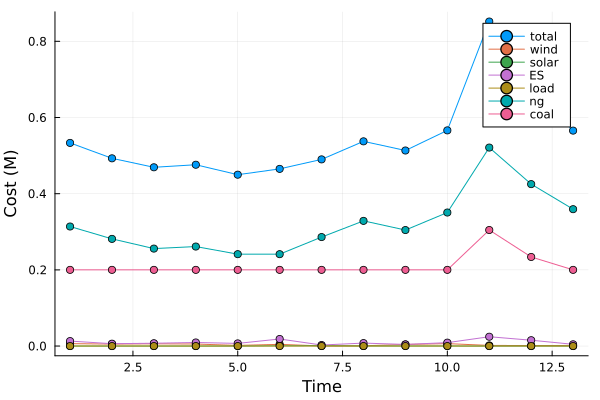

In [19]:
# Plot the cost
figc = plot(oper_cost_rh_1'/1e3, label= "total",markershape =:circle, xlabel = "Time", ylabel = "Cost (M)")
figc = plot!(wind_cost_rh'/1e3, label= "wind",markershape =:circle, xlabel = "Time", ylabel = "Cost (M)")
figc = plot!(solar_cost_rh'/1e3, label= "solar",markershape =:circle, xlabel = "Time", ylabel = "Cost (M)")
figc = plot!(ES_cost_rh'/1e3, label= "ES",markershape =:circle, xlabel = "Time", ylabel = "Cost (M)")
figc = plot!(load_cost_rh'/1e3, label= "load",markershape =:circle, xlabel = "Time", ylabel = "Cost (M)")
figc = plot!(ng_cost_rh'/1e3, label= "ng",markershape =:circle, xlabel = "Time", ylabel = "Cost (M)")
figc = plot!(coal_cost_rh'/1e3, label= "coal",markershape =:circle, xlabel = "Time", ylabel = "Cost (M)")
display(figc)

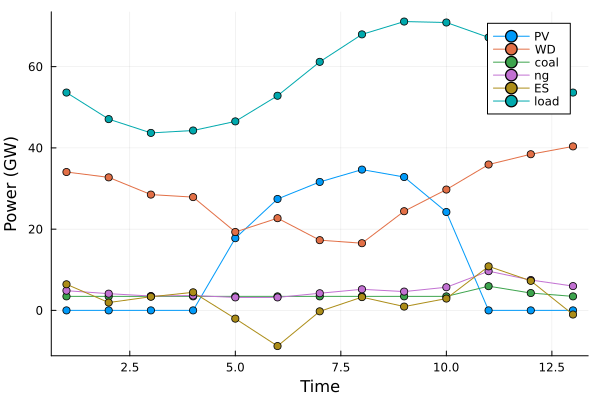

In [20]:
# Plot the cost
figp = plot((sum(p_PV_rh,dims=1)' + sum(p_solar_rh,dims=1)')/1e3, label= "PV",markershape =:circle, xlabel = "Time", ylabel = "Power (GW)")
figp = plot!((sum(p_WD_rh,dims=1)'+ sum(p_wind_rh, dims =1)')/1e3, label= "WD",markershape =:circle, xlabel = "Time", ylabel = "Power (GW)")
figp = plot!(sum(p_coal_rh,dims=1)'/1e3, label= "coal",markershape =:circle, xlabel = "Time", ylabel = "Power (GW)")
figp = plot!(sum(p_ng_rh,dims=1)'/1e3, label= "ng",markershape =:circle, xlabel = "Time", ylabel = "Power (GW)")
figp = plot!(sum(p_dis_rh - p_cha_rh,dims=1)'/1e3, label= "ES",markershape =:circle, xlabel = "Time", ylabel = "Power (GW)")
figp = plot!(sum(p_load_rh,dims=1)'/1e3, label= "load",markershape =:circle, xlabel = "Time", ylabel = "Power (GW)")
display(figp)


In [51]:
c_gen_coal[1,1]*(p_coal_var[1,:].^2)

12-element Vector{QuadExpr}:
 2.18e-6 p_coal_var[1,1]²
 2.18e-6 p_coal_var[1,2]²
 2.18e-6 p_coal_var[1,3]²
 2.18e-6 p_coal_var[1,4]²
 2.18e-6 p_coal_var[1,5]²
 2.18e-6 p_coal_var[1,6]²
 2.18e-6 p_coal_var[1,7]²
 2.18e-6 p_coal_var[1,8]²
 2.18e-6 p_coal_var[1,9]²
 2.18e-6 p_coal_var[1,10]²
 2.18e-6 p_coal_var[1,11]²
 2.18e-6 p_coal_var[1,12]²

In [32]:
oper_cost_rh

1×3 Matrix{Float64}:
 7.89763  7.72146  7.58736

In [26]:
oper_cost_rh[k_rh] = value(Obj_oper)/1e3 

7.897632839924985

In [48]:
# Get and Save optimal solution values
p_PV_op = value.(p_PV_var)
p_WD_op = value.(p_WD_var)
p_solar_op = value.(p_solar_var)
p_wind_op = value.(p_wind_var)
p_coal_op = value.(p_coal_var)
p_ng_op = value.(p_ng_var)
nu_ES_op = value.(nu_ES_var)
p_dis_op = value.(p_dis_var)
p_cha_op = value.(p_cha_var)
e_ES_op = value.(e_ES_var)
P_br_op = value.(P_br_var)
tha_op = value.(tha_var)
P_br_ava_op = P_br_max  - abs.(P_br) #+ cap_br_add*ones(1,num_time_sim)  # ==0: binding line
# p_load_op = p_load_max_t

cost_op = value(Obj_oper)/1e6  # billion $



LoadError: UndefVarError: Obj_oper not defined

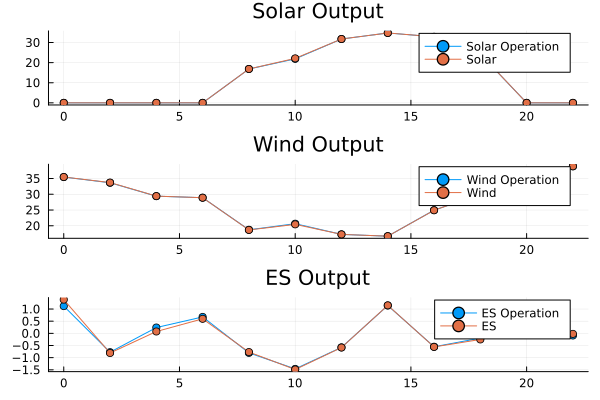

In [17]:
# ============== compare with planning results ===============
P_solar_t = sum(p_PV, dims=1)+sum(p_solar, dims=1)
P_solar_t = P_solar_t'[:,1]
P_solar_t_op = sum(p_PV_op, dims=1)+sum(p_solar_op, dims=1)
P_solar_t_op = P_solar_t_op'[:,1]

fig1 = plot((0:2:22),P_solar_t_op/1e3, markershape =:circle, title = "Solar Output", label = "Solar Operation", lw = 1)
fig1 = plot!((0:2:22),P_solar_t/1e3, markershape =:circle, title = "Solar Output", label = "Solar", lw = 1)


P_wind_t = sum(p_wind, dims=1)+sum(p_WD, dims=1)
P_wind_t = P_wind_t'[:,1]
P_wind_t_op = sum(p_wind_op, dims=1)+sum(p_WD_op, dims=1)
P_wind_t_op = P_wind_t_op'[:,1]

fig2 = plot((0:2:22),P_wind_t_op/1e3, markershape =:circle, title = "Wind Output", label = "Wind Operation", lw = 1)
fig2 = plot!((0:2:22),P_wind_t/1e3, markershape =:circle, title = "Wind Output", label = "Wind", lw = 1)

P_coal_t = sum(p_coal, dims =1)
P_coal_t = P_coal_t'[:,1]

P_ng_t = sum(p_ng, dims =1)
P_ng_t = P_ng_t'[:,1]

P_nuclear_t = sum(P_nuclear, dims =1)
P_nuclear_t = P_nuclear_t'[:,1]

p_ES_t = sum(p_dis, dims = 1) - sum(p_cha, dims = 1)
p_ES_t = p_ES_t'[:,1]

p_ES_t_op = sum(p_dis_op, dims = 1) - sum(p_cha_op, dims = 1)
p_ES_t_op = p_ES_t_op'[:,1]

fig3 = plot((0:2:22),p_ES_t_op/1e3, markershape =:circle, title = "ES Output", label = "ES Operation", lw = 1)
fig3 = plot!((0:2:22),p_ES_t/1e3, markershape =:circle, title = "ES Output", label = "ES", lw = 1)


display(plot(fig1, fig2, fig3, layout = (3, 1), legend = true))

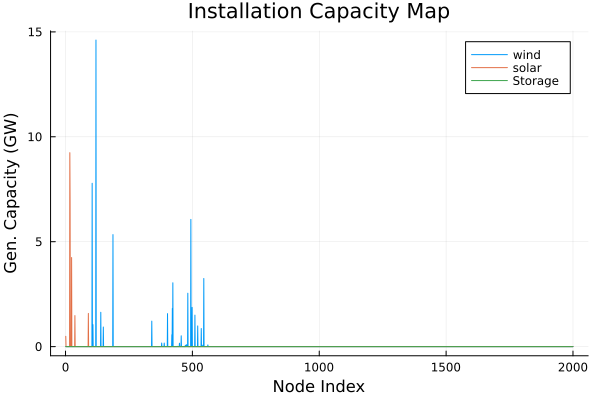

The objective (total cost) is 1.05517174437e8 
Investment Cost: 91.747 billion $
Solar Investment Cost: 21.292 billion $
Wind Investment Cost: 70.455 billion $
Storage Investment Cost: 0.0 billion $
Gas Decommission Cost: 0.941 billion $
Coal Decommission Cost: 0.028 billion $
Line Expansion Cost: 0.0 billion $
Operational Cost: 3507.112 k$


In [26]:

figr = plot(w_WD/1e3, label= "wind")
figr = plot!(w_PV/1e3, label= "solar", xlabel = "Node Index", ylabel = "Gen. Capacity (GW)",  title = "Installation Capacity Map")
figr = plot!(w_ES/1e3, label= "Storage")
display(figr)

# Output Solutions
print("The objective (total cost) is ", round(objective_value(model_plan),digits =3)," \n")
print("Investment Cost: ", round(value(Obj_invest+ Obj_line_expansion)/1e6,digits =3), " billion \$\n")
print("Solar Investment Cost: ", round(sum(c_PV_invest*(w_PV))/1e6,digits =3), " billion \$\n")
print("Wind Investment Cost: ", round(sum(c_WD_invest*w_WD)/1e6,digits =3), " billion \$\n")
print("Storage Investment Cost: ", round(sum(c_ES_invest*w_ES)/1e6,digits =3), " billion \$\n")
print("Gas Decommission Cost: ", round(value(Obj_retire_ng)/1e6,digits =3), " billion \$\n")
print("Coal Decommission Cost: ", round(value(Obj_retire_coal )/1e6,digits =3), " billion \$\n")
print("Line Expansion Cost: ", round(value(Obj_line_expansion)/1e6,digits =3), " billion \$\n")
print("Operational Cost: ", round(value(Obj_opera),digits =3), " k\$\n")

In [13]:
# Save and Read Data
using JLD2, Tables
# jldsave("ERCOT_Test_Save\\Testcase_3.jld2"; w_PV, p_PV, w_WD, p_WD, p_solar, p_wind, z_coal, p_coal,
#                             z_ng, p_ng, nu_ES, w_ES, y_ES, p_dis, p_cha, e_ES, P_br, tha, P_br_ava,cap_br_add);

CSV.write("ERCOT_Test_Save\\solarinstall_26.csv", Tables.table(w_PV), writeheader=false)
CSV.write("ERCOT_Test_Save\\windinstall_26.csv", Tables.table(w_WD), writeheader=false)
CSV.write("ERCOT_Test_Save\\storageinstall_26.csv", Tables.table(w_ES), writeheader=false)
CSV.write("ERCOT_Test_Save\\linepowerextra_26.csv", Tables.table(P_br_ava), writeheader=false)

br_bind_index = zeros(num_branch,num_time_sim)
for i = 1:num_branch
    for t = 1:num_time_sim
       if P_br_ava[i,t] <= 1e-4
           br_bind_index[i,t] = 1
       end
    end
end

CSV.write("ERCOT_Test_Save\\linebind_26.csv", Tables.table(br_bind_index), writeheader= false)

LoadError: UndefVarError: writeshortest not defined

solar cap: 26.384 GW (20.472%) 
wind cap: 77.194 GW (59.898%) 
natural gas cap: 5.899 GW (4.578%) 
coal cap: 14.26 GW (11.065%) 
nuclear cap: 5.139 GW (3.987%) 
total generation capacity: 128.875 GW 


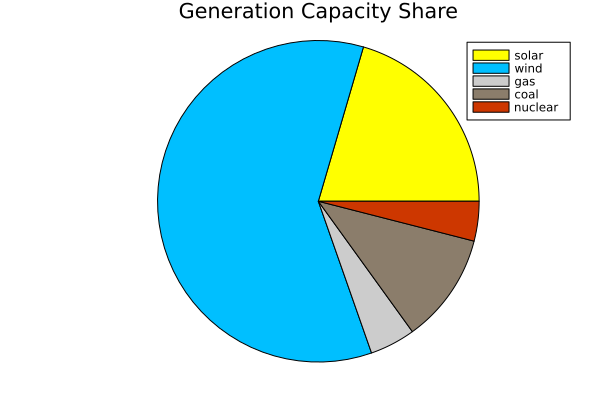

In [14]:
# Total Installation capacity
C_solar = (sum(w_PV) + sum(plant_data_solar.Pmax))/1e3
C_wind = (sum(w_WD) + sum(plant_data_wind.Pmax))/1e3
C_coal = sum(z_coal.*Pmax_coal[:,1])/1e3
C_ng = sum(z_ng.*Pmax_ng[:,1])/1e3
C_nuclear = sum(plant_data_nuclear.Pmax)/1e3
C_gen = C_solar+C_wind+C_coal+C_ng+C_nuclear

print("solar cap: ", round(C_solar, digits =3), " GW (", round(C_solar/C_gen*100, digits =3), "%) \n", 
      "wind cap: ", round(C_wind, digits =3), " GW (", round(C_wind/C_gen*100, digits =3), "%) \n", 
      "natural gas cap: ", round(C_ng, digits =3), " GW (", round(C_ng/C_gen*100, digits =3), "%) \n", 
      "coal cap: ",  round(C_coal, digits =3), " GW (", round(C_coal/C_gen*100, digits =3), "%) \n", 
      "nuclear cap: ",  round(C_nuclear, digits =3), " GW (", round(C_nuclear/C_gen*100, digits =3), "%) \n", 
   #   "clean energy: ",  round(C_nuclear+E_solar+E_wind, digits =3), " MWh (", round((E_nuclear+E_solar+E_wind)/E_gen*100, digits =3), "%) \n", 
      "total generation capacity: ", round(C_gen, digits =3), " GW \n",
     # "total load: ", round(C_load, digits =3), " MWh \n" 
    )


labels = ["solar"; "wind"; "gas";"coal"; "nuclear"] 
sizes = [C_solar; C_wind; C_ng; C_coal; C_nuclear]
# fig_energy = plot(labels, sizes,seriestype = :pie, title = "Generation Energy Share" )
fig_energy = pie(labels, sizes, color = [:yellow, :deepskyblue1, :gray80, :bisque4, :orangered3] ,title = "Generation Capacity Share" )
display(fig_energy)

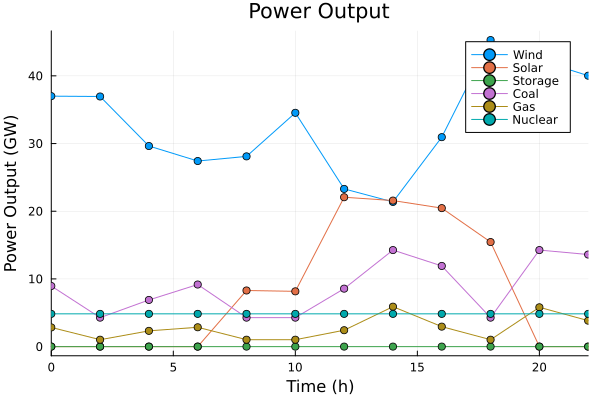

In [15]:
P_solar_t = sum(p_PV, dims=1)+sum(p_solar, dims=1)
P_solar_t = P_solar_t'[:,1]

P_wind_t = sum(p_wind, dims=1)+sum(p_WD, dims=1)
P_wind_t = P_wind_t'[:,1]

P_coal_t = sum(p_coal, dims =1)
P_coal_t = P_coal_t'[:,1]

P_ng_t = sum(p_ng, dims =1)
P_ng_t = P_ng_t'[:,1]

P_nuclear_t = sum(P_nuclear, dims =1)
P_nuclear_t = P_nuclear_t'[:,1]

p_ES_t = sum(p_dis, dims = 1) - sum(p_cha, dims = 1)
p_ES_t = p_ES_t'[:,1]

plot((0:2:22),P_wind_t/1e3, markershape =:circle, title = "Generation Output", label = "Wind", lw = 1)
plot!((0:2:22),P_solar_t/1e3, markershape =:circle, title = "Generation Output", label = "Solar", lw = 1)
plot!((0:2:22),p_ES_t/1e3, markershape =:circle, title = "Generation Output", label = "Storage", lw = 1)
plot!((0:2:22),P_coal_t/1e3, markershape =:circle, title = "Generation Output", label = "Coal", lw = 1)
plot!((0:2:22),P_ng_t/1e3, markershape =:circle, title = "Generation Output", label = "Gas", lw = 1)
plot!((0:2:22),P_nuclear_t/1e3, markershape =:circle, title = "Power Output", label = "Nuclear", xlims = (0,22), xlabel = "Time (h)", ylabel = "Power Output (GW)", lw = 1)

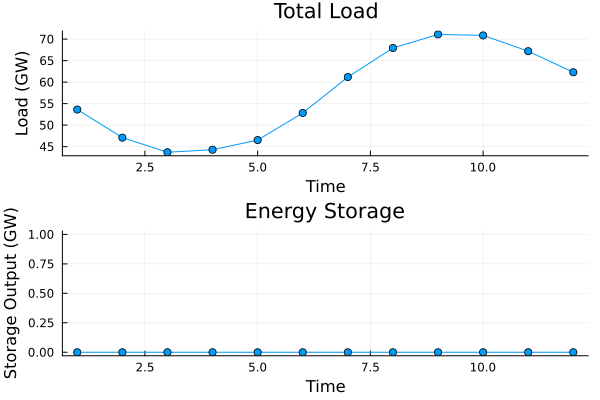

In [16]:
# Load
P_load_t = sum(value.(p_load_max_t), dims = 1)
r1fig = plot(P_load_t'/1e3, markershape =:circle, xlabel = "Time", ylabel = "Load (GW)", title = "Total Load")

# Energy Storage
# p_ES_t = sum(value.(p_ES_var), dims = 1)
p_ES_t = sum(value.(p_cha_var - p_dis_var), dims = 1)
r2fig = plot(p_ES_t'/1e3,  xlabel = "Time", ylabel = "Storage Output (GW)", title = "Energy Storage", markershape =:circle)

display(plot(r1fig, r2fig, layout = (2, 1), legend = false))

In [17]:
# Read Existing Solution Results
datafile = jldopen("ERCOT_Test_Save\\Testcase_17.jld2", "r")
w_PV = read(datafile, "w_PV")
p_PV = read(datafile, "p_PV") 
w_WD = read(datafile, "w_WD")
p_WD = read(datafile, "p_WD") 
p_solar = read(datafile, "p_solar")
p_wind = read(datafile, "p_wind")
z_coal = read(datafile, "z_coal")
p_coal = read(datafile, "p_coal")
z_ng = read(datafile, "z_ng")
p_ng = read(datafile, "p_ng") 
nu_ES = read(datafile, "nu_ES") 
w_ES = read(datafile, "w_ES")
y_ES = read(datafile, "y_ES")
p_dis = read(datafile, "p_dis") 
p_cha = read(datafile, "p_cha") 
e_ES = read(datafile, "e_ES") 
P_br = read(datafile, "P_br") 
tha = read(datafile, "tha")
P_br_ava = read(datafile, "P_br_ava")
cap_br_add = read(datafile, "cap_br_add")
close(datafile)
print("New solar installation cap: ", round(sum(w_PV)/1e3, digits =3)," (GW)\n")
print("New wind installation cap: ", round(sum(w_WD)/1e3, digits =3)," (GW)\n")
print("New energy storage installation cap: ", round(sum(w_ES)/1e3, digits =3)," (GWh)\n")
print("Solar Investment Cost: ", round(sum(c_PV_invest*(w_PV))/1e6,digits =3), " billion \$\n")
print("Wind Investment Cost: ", round(sum(c_WD_invest*w_WD)/1e6,digits =3), " billion \$\n")
print("Storage Investment Cost: ", round(sum(c_ES_invest*w_ES)/1e6,digits =3), " billion \$\n")

New solar installation cap: 33.503 (GW)
New wind installation cap: 57.062 (GW)
New energy storage installation cap: 1.211 (GWh)
Solar Investment Cost: 29.817 billion $
Wind Investment Cost: 69.159 billion $
Storage Investment Cost: 0.447 billion $


In [18]:
Obj_opera =  c_curtail*(sum( w_PV.*coe_PV_t - p_PV) + sum( w_WD.*coe_WD_t - p_WD)
           + sum(Pmax_wind - p_wind) + sum(Pmax_solar-p_solar)) + c_ES_oper*sum(p_dis + p_cha)
         # + c_loadshed*sum(p_load_max_t - p_load_var)
         
for i = 1:num_gen_coal
    Obj_opera =  Obj_opera + sum(c_gen_coal[i,2]*p_coal[i,:] + z_coal[i]*c_gen_coal[i,3]*ones(num_time_sim,1))
                       + sum(c_gen_coal[i,1]*(p_coal[i,:].^2) )
end

for i = 1:num_gen_ng
    Obj_opera =  Obj_opera + sum( c_gen_ng[i,2]*p_ng[i,:] + z_ng[i]*c_gen_ng[i,3]*ones(num_time_sim,1))
                       + sum(c_gen_ng[i,1]*(p_ng[i,:].^2))
end

In [73]:
br_add_index = zeros(num_branch,1)
for i = 1:num_branch
    if cap_br_add[i] >= 1e-2
        br_add_index[i] = 1
    end
end
CSV.write("ERCOT_Test_Save\\lineadd_17.csv", Tables.table(br_add_index), writeheader= false)

"ERCOT_Test_Save\\lineadd_17.csv"

In [72]:
sum(br_add_index)

194.0

In [42]:
print("solar: ", round(E_solar, digits =3), " GWh (", round(E_solar/E_gen*100, digits =3), "%) \n", 
      "wind: ", round(E_wind, digits =3), " GWh (", round(E_wind/E_gen*100, digits =3), "%) \n", 
      "natural gas: ", round(E_ng, digits =3), " GWh (", round(E_ng/E_gen*100, digits =3), "%) \n", 
      "coal: ",  round(E_coal, digits =3), " GWh (", round(E_coal/E_gen*100, digits =3), "%) \n", 
      "nuclear: ",  round(E_nuclear, digits =3), " GWh (", round(E_nuclear/E_gen*100, digits =3), "%) \n", 
      "clean energy: ",  round(E_nuclear+E_solar+E_wind, digits =3), " GWh (", round((E_nuclear+E_solar+E_wind)/E_gen*100, digits =3), "%) \n", 
      "total generation: ", round(E_gen, digits =3), " GWh \n",
      "total load: ", 688597*2/1000, " GWh \n")

solar: 323.54 GWh (23.485%) 
wind: 662.589 GWh (48.096%) 
natural gas: 172.99 GWh (12.557%) 
coal: 102.449 GWh (7.437%) 
nuclear: 116.064 GWh (8.425%) 
clean energy: 1102.192 GWh (80.006%) 
total generation: 1377.631 GWh 
total load: 1377.194 GWh 


In [20]:
# Save and Read Data
using JLD2, Tables
jldsave("ERCOT_Test_Save\\Testcase_3.jld2"; w_PV, p_PV, w_WD, p_WD, p_solar, p_wind, z_coal, p_coal,
                            z_ng, p_ng, nu_ES, w_ES, y_ES, p_dis, p_cha, e_ES, P_br, tha, P_br_ava); #,cap_br_add);

CSV.write("ERCOT_Test_Save\\solarinstall_3.csv", Tables.table(w_PV), writeheader=false)
CSV.write("ERCOT_Test_Save\\windinstall_3.csv", Tables.table(w_WD), writeheader=false)
CSV.write("ERCOT_Test_Save\\storageinstall_3.csv", Tables.table(w_ES), writeheader=false)
CSV.write("ERCOT_Test_Save\\linepowerextra_3.csv", Tables.table(P_br_ava), writeheader=false)

br_bind_index = zeros(num_branch,num_time_sim)
for i = 1:num_branch
    for t = 1:num_time_sim
       if P_br_ava[i,t] <= 1e-4
           br_bind_index[i,t] = 1
       end
    end
end

CSV.write("ERCOT_Test_Save\\linebind_3s.csv", Tables.table(br_bind_index), writeheader= false)

# # Read Existing Solution Results
# datafile = jldopen("Testcase_14.jld2", "r")
# w_PV = read(datafile, "w_PV")
# p_PV = read(datafile, "p_PV") 
# w_WD = read(datafile, "w_WD")
# p_WD = read(datafile, "p_WD") 
# p_solar = read(datafile, "p_solar")
# p_wind = read(datafile, "p_wind")
# z_coal = read(datafile, "z_coal")
# p_coal = read(datafile, "p_coal")
# z_ng = read(datafile, "z_ng")
# p_ng = read(datafile, "p_ng") 
# nu_ES = read(datafile, "nu_ES") 
# w_ES = read(datafile, "w_ES")
# y_ES = read(datafile, "y_ES")
# p_dis = read(datafile, "p_dis") 
# p_cha = read(datafile, "p_cha") 
# e_ES = read(datafile, "e_ES") 
# P_br = read(datafile, "P_br") 
# tha = read(datafile, "tha")
# P_br_ava = read(datafile, "P_br_ava")
# close(datafile)

"ERCOT_Test_Save\\linebind_3s.csv"

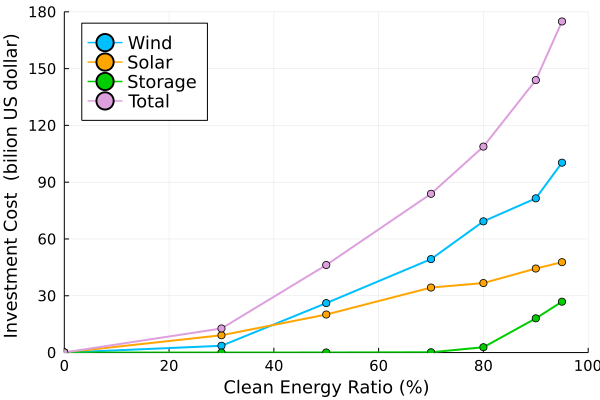

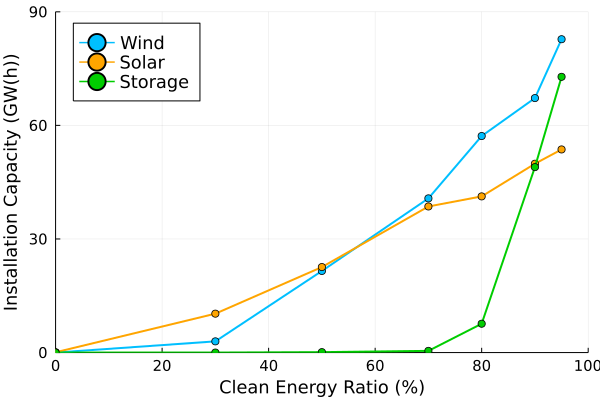

In [46]:
# Plot for the case with no line capacity expansion
c_PV_invest = 890 # k$/MW
c_WD_invest = 1212 # k$/MW
c_ES_invest = 369 # k$/MWh
c_curtail = 0.002 # k$/MWh
c_ES_oper = 0.001  # k$/MWh
c_loadshed = 5  # k$/MWh
c_coal_retire = 117 # k$/MW
c_ng_retire = 15 # k$/MW
Invest_result = [0 0.07 0 0.078 0;
                 30 12.726 2.957 10.272 0;
                 50 46.258 21.551 22.582 0.108;
                 70 83.867 40.725 38.588 0.447;
                 80 108.8 57.189 41.247 7.615;
                 90 143.92 67.212 49.876 48.979;
                 95 174.9 82.759 53.647 72.827]
solar_inv = Invest_result[:,4]*c_PV_invest
wind_inv = Invest_result[:,3]*c_WD_invest
ES_inv = Invest_result[:,5]*c_ES_invest
f1inv = plot(Invest_result[:,1], wind_inv/1e3 ,color = :deepskyblue, label = "Wind", legend=:topleft,xlabel = "Clean Energy Ratio (%)", xlims = (0,100), ylims = (0,180), ylabel = "Investment Cost  (bilion US dollar) ",  markershape =:circle, xtickfontsize=10,ytickfontsize=10,xguidefontsize=12, yguidefontsize=12,legendfontsize=12,linewidth=2)
f1inv = plot!(Invest_result[:,1], solar_inv/1e3 , color = :orange, label = "Solar", legend=:topleft,xlabel = "Clean Energy Ratio (%)", xlims = (0,100), ylims = (0,180), ylabel = "Investment Cost  (bilion US dollar) ",  markershape =:circle, xtickfontsize=10,ytickfontsize=10,xguidefontsize=12, yguidefontsize=12,legendfontsize=12,linewidth=2)
f1inv = plot!(Invest_result[:,1], ES_inv/1e3 ,color = :green3, label = "Storage", legend=:topleft,xlabel = "Clean Energy Ratio (%)", xlims = (0,100), ylims = (0,180), ylabel = "Investment Cost  (bilion US dollar) ",  markershape =:circle, xtickfontsize=10,ytickfontsize=10,xguidefontsize=12, yguidefontsize=12,legendfontsize=12,linewidth=2)
f1inv = plot!(Invest_result[:,1], Invest_result[:,2], color = :plum, label = "Total", legend=:topleft,xlabel = "Clean Energy Ratio (%)", xlims = (0,100), ylims = (0,180), ylabel = "Investment Cost  (bilion US dollar) ",  markershape =:circle, xtickfontsize=10,ytickfontsize=10,xguidefontsize=12, yguidefontsize=12,legendfontsize=12,linewidth=2)


display(f1inv)
f2inv = plot(Invest_result[:,1], Invest_result[:,3],color = :deepskyblue, legend=:topleft, label = "Wind", xlabel = "Clean Energy Ratio (%)", ylabel = "Installation Capacity (GW(h))",  markershape =:circle, xtickfontsize=10,ytickfontsize=10,xguidefontsize=12, yguidefontsize=12,legendfontsize=12,linewidth=2)
f2inv = plot!(Invest_result[:,1], Invest_result[:,4], color = :orange, legend=:topleft,label = "Solar", xlabel = "Clean Energy Ratio (%)", ylabel = "Installation Capacity (GW(h))",  markershape =:circle, xtickfontsize=10,ytickfontsize=10,xguidefontsize=12, yguidefontsize=12,legendfontsize=12,linewidth=2)
f2inv = plot!(Invest_result[:,1], Invest_result[:,5],color = :green3, legend=:topleft,label = "Storage", xlims = (0,100),ylims = (0,90), xlabel = "Clean Energy Ratio (%)", ylabel = "Installation Capacity (GW(h))",  markershape =:circle, xtickfontsize=10,ytickfontsize=10,xguidefontsize=12, yguidefontsize=12,legendfontsize=12,linewidth=2)
display(f2inv)

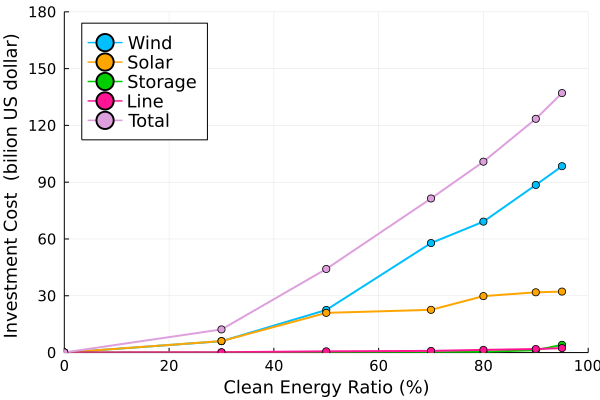

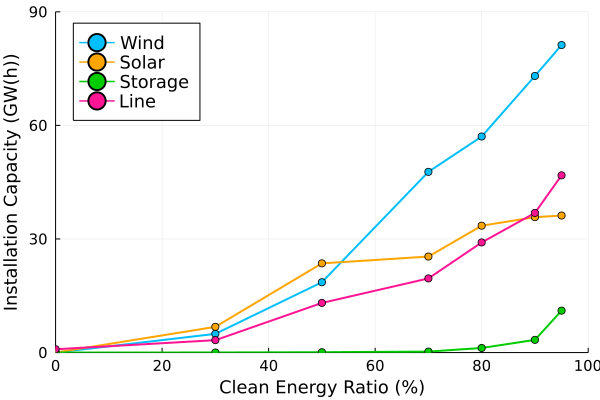

In [45]:
# Plot for the case with line capacity expansion
c_PV_invest = 890 # k$/MW
c_WD_invest = 1212 # k$/MW
c_ES_invest = 369 # k$/MWh
c_curtail = 0.002 # k$/MWh
c_ES_oper = 0.001  # k$/MWh
c_loadshed = 5  # k$/MWh
c_coal_retire = 117 # k$/MW
c_ng_retire = 15 # k$/MW

# ≥Renewable Ratio	Wind Inst Cap. (GW)	Solar Inst. Cap. (GW)	Storage Cap. (GWh)	Line Expan. Cap. (GW)	Wind Invest (billion $)	Solar Inv	Storage Inv	Line Inv	Total Inv
Invest_result = [0	0	0.008	0	0.878	0	0.008	0	0.059	0.067
30	4.944	6.796	0.019	3.273	5.993	6.048	0.007	0.171	12.219
50	18.574	23.558	0.089	13.11	22.511	20.966	0.033	0.643	44.153
70	47.733	25.361	0.256	19.584	57.852	22.571	0.094	0.876	81.393
80	57.062	33.503	1.211	29.087	69.159	29.817	0.447	1.404	100.827
90	73.058	35.765	3.356	36.88	88.546	31.83	1.238	1.861	123.475
95	81.224	36.187	11.068	46.806	98.443	32.206	4.084	2.35	137.083]

solar_inv = Invest_result[:,4]*c_PV_invest
wind_inv = Invest_result[:,3]*c_WD_invest
ES_inv = Invest_result[:,5]*c_ES_invest
f1inv = plot(Invest_result[:,1], Invest_result[:,6] , color = :deepskyblue, label = "Wind", legend=:topleft,xlabel = "Clean Energy Ratio (%)", xlims = (0,100), ylims = (0,180), ylabel = "Investment Cost  (bilion US dollar) ",  markershape =:circle, xtickfontsize=10,ytickfontsize=10,xguidefontsize=12, yguidefontsize=12,legendfontsize=12,linewidth=2)
f1inv = plot!(Invest_result[:,1], Invest_result[:,7] , color = :orange, label = "Solar", legend=:topleft,xlabel = "Clean Energy Ratio (%)", xlims = (0,100), ylims = (0,180), ylabel = "Investment Cost  (bilion US dollar) ",  markershape =:circle, xtickfontsize=10,ytickfontsize=10,xguidefontsize=12, yguidefontsize=12,legendfontsize=12,linewidth=2)
f1inv = plot!(Invest_result[:,1], Invest_result[:,8],color = :green3, label = "Storage", legend=:topleft,xlabel = "Clean Energy Ratio (%)", xlims = (0,100), ylims = (0,180), ylabel = "Investment Cost  (bilion US dollar) ",  markershape =:circle, xtickfontsize=10,ytickfontsize=10,xguidefontsize=12, yguidefontsize=12,legendfontsize=12,linewidth=2)
f1inv = plot!(Invest_result[:,1], Invest_result[:,9], color = :deeppink, label = "Line", legend=:topleft,xlabel = "Clean Energy Ratio (%)", xlims = (0,100), ylims = (0,180), ylabel = "Investment Cost  (bilion US dollar) ",  markershape =:circle, xtickfontsize=10,ytickfontsize=10,xguidefontsize=12, yguidefontsize=12,legendfontsize=12,linewidth=2)
f1inv = plot!(Invest_result[:,1], Invest_result[:,10],color = :plum, label = "Total", legend=:topleft,xlabel = "Clean Energy Ratio (%)", xlims = (0,100), ylims = (0,180), ylabel = "Investment Cost  (bilion US dollar) ",  markershape =:circle, xtickfontsize=10,ytickfontsize=10,xguidefontsize=12, yguidefontsize=12,legendfontsize=12,linewidth=2)
display(f1inv)

f2inv = plot(Invest_result[:,1], Invest_result[:,2],color = :deepskyblue, legend=:topleft, label = "Wind", xlabel = "Clean Energy Ratio (%)", ylabel = "Installation Capacity (GW(h))",  markershape =:circle, xtickfontsize=10,ytickfontsize=10,xguidefontsize=12, yguidefontsize=12,legendfontsize=12,linewidth=2)
f2inv = plot!(Invest_result[:,1], Invest_result[:,3],color = :orange, legend=:topleft,label = "Solar", xlabel = "Clean Energy Ratio (%)", ylabel = "Installation Capacity (GW(h))",  markershape =:circle, xtickfontsize=10,ytickfontsize=10,xguidefontsize=12, yguidefontsize=12,legendfontsize=12,linewidth=2)
f2inv = plot!(Invest_result[:,1], Invest_result[:,4],color = :green3,  legend=:topleft,label = "Storage", xlims = (0,100),ylims = (0,90), xlabel = "Clean Energy Ratio (%)", ylabel = "Installation Capacity (GW(h))",  markershape =:circle, xtickfontsize=10,ytickfontsize=10,xguidefontsize=12, yguidefontsize=12,legendfontsize=12,linewidth=2)
f2inv = plot!(Invest_result[:,1], Invest_result[:,5],color = :deeppink,legend=:topleft,label = "Line", xlims = (0,100),ylims = (0,90), xlabel = "Clean Energy Ratio (%)", ylabel = "Installation Capacity (GW(h))",  markershape =:circle, xtickfontsize=10,ytickfontsize=10,xguidefontsize=12, yguidefontsize=12,legendfontsize=12,linewidth=2)

display(f2inv)